In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri
import doubletdetection as dd
from gseapy.plot import barplot, dotplot
import os, sys
import gseapy as gp
from anndata import AnnData

import scipy.stats
import diffxpy.api as de
import anndata
from batchglm.api.models.tf1.glm_nb import Simulator

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()


plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 0   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white')
sc.logging.print_versions()
sc.logging.print_header()

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
%load_ext rpy2.ipython

%matplotlib inline

plt.rcParams.update({'font.size': 22})

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
Crypto                                      3.10.1
OpenSSL                                     20.0.1
PIL                                         8.1.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
anndata                                     0.7.5
anndata2ri                                  1.0.6
appdirs                                     1.4.4
asciitree                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
backports                                   NA
batchglm                                    v0.7.4
bcrypt                                      3.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
bioservices                                 1.7.11
boto3                                       1.17.107
botocore                                    1

In [2]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths("/home/dan/R/x86_64-pc-linux-gnu-library/4.03")
#Sys.setenv(R_INSTALL_STAGED = FALSE)

#sudo apt-get install aptitude

#sudo apt-get install libcurl4-openssl-dev

#sudo apt-get install libxml2-dev

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
#library(scCB2)
#library(DropletUtils)
library(Seurat)
library(NMF)
library(BiocFileCache)

In [3]:
import pickle

# Getting back the objects:
with open('adata_cluster_annotations2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata = pickle.load(f)

In [4]:
mycolormap_26 = ["#66cdaa","#0054b4","#966fd6","#aec6cf","red",
                "#ffb347","#e5aa70","#db7093","#cc99a2", "#03c03c",
                "#24F4FF", "#5a5a97", "#5b5da7", "#caae6b", "pink",
                 "#ba4747",  "yellow", "#555f6d", "gray", "#cc99a2",
                "#6f9dab", "#557100", "#caae6b", "#f1b929", "orange"]

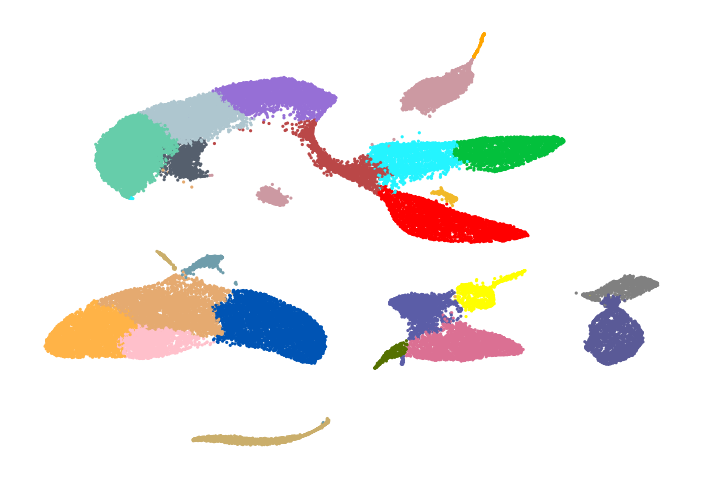

In [10]:
sc.pl.umap(adata, color='leiden_r1', size=10, legend_loc=None, 
           title = '', frameon=False,
           palette = mycolormap_26, 
           show = True, save = 'cluster_name4.pdf')

In [16]:
adata.layers['counts'].shape

(48926, 19854)

In [14]:
adata.X = adata.layers['counts']

In [31]:
adata.var.drop(columns=[2], inplace = True)

In [47]:
adata_mesenchymal = adata[adata.obs['leiden_r1'].isin(['Fibroblasts_1', 'Fibroblasts_2', 'Fibroblasts_3', 'Fibroblasts_4', 'Fibroblasts_5'])]

In [48]:
# the transposed matrix with columns cells and rows genes
# log-normalized no scaled data in adata.raw and adata_test
from scipy.sparse import csr_matrix
csr_matrix = csr_matrix(adata_mesenchymal.X.T)

In [49]:
adata_mesenchymal.obs.index.name = 'cells'

In [50]:
adata_mesenchymal.obs.index.name

'cells'

In [51]:
# cell data 48926 rows
cData = adata_mesenchymal.obs

In [52]:
%%R -i csr_matrix
library(MAST)
class(csr_matrix)

[1] "dgRMatrix"
attr(,"package")
[1] "Matrix"


In [54]:
%%R -i cData
str(cData)

'data.frame':	12591 obs. of  16 variables:
 $ sample       : Factor w/ 4 levels "E4A","E4Ap53",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ age          : Factor w/ 2 levels "2weeks","4months": 1 1 1 1 1 1 1 1 1 1 ...
 $ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ genotype_age : Factor w/ 8 levels "TY_2weeks","TY_4months",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ n_counts     : num  3136 3155 1810 1588 2016 ...
 $ log_counts   : num  8.07 8.09 7.53 7.4 7.63 ...
 $ n_genes      : int  1497 1538 1022 812 1072 1045 1057 1499 1152 1188 ...
 $ mt_frac      : num  0.02 0.0286 0.0295 0.0335 0.018 ...
 $ doublet      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ doublet_score: num  1.75e-44 1.75e-44 8.16e-61 2.76e-18 1.63e-52 ...
 $ S_score      : num  0.0133 0.1278 0.0707 -0.0377 -0.0334 ...
 $ G2M_score    : num  -0.0517 -0.0799 -0.1078 -0.0292 -0.059 ...
 $ phase        : Factor w/ 3 levels "G1","G2M","S": 3 3 3 1 1 2 1 2 1 1 ...
 $ leiden_r1    : Factor w/ 5 levels "Fibroblasts_1",..: 2 2 2 1 2 3

In [56]:
# 19854 genes
fData = adata_mesenchymal.var

In [57]:
%%R -i fData
str(fData)

'data.frame':	19854 obs. of  8 variables:
 $ gene_id         : Factor w/ 19853 levels "0610005C13Rik",..: 19853 5208 4167 5209 19853 19169 15232 16666 11840 11139 ...
 $ n_cells         : int  9304 10407 163 6591 720 18 16 832 11394 9614 ...
 $ highly_variable : logi  TRUE FALSE FALSE TRUE FALSE FALSE ...
 $ means           : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ dispersions     : num  1.427 0.835 1.236 2.531 1.187 ...
 $ dispersions_norm: num  8.13 1.5 3.41 19.76 3.15 ...
 $ mean            : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ std             : num  0.5924 0.3579 0.0627 0.8143 0.1101 ...


In [58]:
%%R
sca <- MAST::FromMatrix(
    as.matrix(csr_matrix), 
    cData,
    fData,
    class = "SingleCellAssay"
)

In [59]:
%%R
save(sca, file=paste0("./adata_mesenchymal", Sys.Date(),".rda"))

In [4]:
%%R
load("adata_mesenchymal2022-02-23.rda")

In [60]:
%%R
head(sca)

class: SingleCellAssay 
dim: 6 12591 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(12591): wk00001 wk00002 ... wk12590 wk12591
colData names(17): sample age ... Ar_status wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [63]:
%%R
# sca columns cells and rows genes
library(MAST)
head(colData(sca))

        sample    age batch genotype_age n_counts log_counts n_genes
wk00001     TY 2weeks     1    TY_2weeks     3136   8.070906    1497
wk00002     TY 2weeks     1    TY_2weeks     3155   8.085794    1538
wk00003     TY 2weeks     1    TY_2weeks     1810   7.531016    1022
wk00004     TY 2weeks     1    TY_2weeks     1588   7.404279     812
wk00005     TY 2weeks     1    TY_2weeks     2016   7.627058    1072
wk00006     TY 2weeks     1    TY_2weeks     2774   7.928406    1045
             mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001 0.0199999996       0  1.752931e-44  0.01330800 -0.05170739     S
wk00002 0.0286330041       0  1.752931e-44  0.12779161 -0.07991821     S
wk00003 0.0294906162       0  8.157960e-61  0.07069504 -0.10780249     S
wk00004 0.0334753506       0  2.756794e-18 -0.03772514 -0.02919422    G1
wk00005 0.0180224068       0  1.627834e-52 -0.03343743 -0.05896644    G1
wk00006 0.0003603604       0  5.156424e-38 -0.02245252  0.05333763   G2M
      

In [64]:
%%R
# sca columns cells and rows genes
length(rowData(sca)$gene_id)

[1] 19854


#### compare Foxf1 and Ar positive cells

#### Differential Expression using a Hurdle model 

In [65]:
%%R
head(colData(sca)$n_genes)

[1] 1497 1538 1022  812 1072 1045


In [66]:
%%R
levels(droplevels(colData(sca)$sample))

[1] "E4A"    "E4Ap53" "EWT"    "TY"    


In [67]:
%%R
colData(sca)$leiden_r1 <- as.factor(as.character(colData(sca)$sample))

In [68]:
%%R
levels(colData(sca)$sample)

[1] "E4A"    "E4Ap53" "EWT"    "TY"    


In [69]:
%%R
head(colData(sca)$n_genes)

[1] 1497 1538 1022  812 1072 1045


In [70]:
%%R
print("Dimensions before subsetting:")
print(dim(sca))
# filter out the not expressed genes
sca_filt = sca[rowSums(assay(sca)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_filt))

[1] "Dimensions before subsetting:"
[1] 19854 12591
[1] "Dimensions after subsetting:"
[1] 19236 12591


In [71]:
%%R
save(sca_filt, file="./MAST/stroma_cells_sca_filt.rda")

In [72]:
%%R
colData(sca_filt)$n_genes = scale(colData(sca_filt)$n_genes)

In [73]:
%%R
mean(colData(sca_filt)$n_genes)

[1] 2.564332e-16


In [74]:
%%R
sd(colData(sca_filt)$n_genes)

[1] 1


In [75]:
%%R
head(colData(sca_filt)$n_genes)

           [,1]
[1,] -0.5590036
[2,] -0.5032547
[3,] -1.2048746
[4,] -1.4904175
[5,] -1.1368882
[6,] -1.1736008


In [76]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond <- zlm(formula = ~Foxf1_status + n_genes, sca=sca_filt, method = "glm")
zlmCond

Fitted zlm on 19236 genes and 12591 cells.
 Using GLMlike ~ Foxf1_status + n_genes 


In [78]:
%%R
summary <- summary(zlmCond, logFC = TRUE, doLRT = 'Foxf1_status')
summary

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid Foxf1_status n_genes
 p05982    -24.1*       -29.9 
 p08734     -2.3         56.6*
 p16408     -3.3         60.9*
 p18559    -24.8*        -8.0 


In [79]:
%%R
save(summary, file="./MAST/Foxf1_status/summary.rda")

In [337]:
%%R
load("./MAST/Foxf1_status/summary.rda")

In [81]:
%%R
head(summary$datatable)

  primerid component     contrast Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C Foxf1_status  0.6463450  0.06773958 -0.11003863
2   p00001         C  (Intercept)         NA  7.94014673  7.87308972
3   p00001         C      n_genes         NA -0.77013642 -0.83354328
4   p00001         D Foxf1_status  0.5381267  0.10765058 -0.20566242
5   p00001         D  (Intercept)         NA -1.97556924 -2.09408170
6   p00001         D      n_genes         NA  0.18052634  0.07245917
         coef           z
1 -0.02114952  -0.4663373
2  7.90661822 462.1943984
3 -0.80183985 -49.5712049
4 -0.04900592  -0.6131239
5 -2.03482547 -67.3040599
6  0.12649276   4.5882804


In [82]:
%%R
summaryDt = summary$datatable
head(summaryDt)

  primerid component     contrast Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C Foxf1_status  0.6463450  0.06773958 -0.11003863
2   p00001         C  (Intercept)         NA  7.94014673  7.87308972
3   p00001         C      n_genes         NA -0.77013642 -0.83354328
4   p00001         D Foxf1_status  0.5381267  0.10765058 -0.20566242
5   p00001         D  (Intercept)         NA -1.97556924 -2.09408170
6   p00001         D      n_genes         NA  0.18052634  0.07245917
         coef           z
1 -0.02114952  -0.4663373
2  7.90661822 462.1943984
3 -0.80183985 -49.5712049
4 -0.04900592  -0.6131239
5 -2.03482547 -67.3040599
6  0.12649276   4.5882804


In [83]:
%%R -o summaryDt
head(summaryDt)

  primerid component     contrast Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C Foxf1_status  0.6463450  0.06773958 -0.11003863
2   p00001         C  (Intercept)         NA  7.94014673  7.87308972
3   p00001         C      n_genes         NA -0.77013642 -0.83354328
4   p00001         D Foxf1_status  0.5381267  0.10765058 -0.20566242
5   p00001         D  (Intercept)         NA -1.97556924 -2.09408170
6   p00001         D      n_genes         NA  0.18052634  0.07245917
         coef           z
1 -0.02114952  -0.4663373
2  7.90661822 462.1943984
3 -0.80183985 -49.5712049
4 -0.04900592  -0.6131239
5 -2.03482547 -67.3040599
6  0.12649276   4.5882804


In [84]:
summaryDt

,primerid,component,contrast,Pr(>Chisq),ci.hi,ci.lo,coef,z
1,p00001,C,Foxf1_status,0.646345,0.067740,-0.110039,-0.021150,-0.466337
2,p00001,C,(Intercept),NaN,7.940147,7.873090,7.906618,462.194398
3,p00001,C,n_genes,NaN,-0.770136,-0.833543,-0.801840,-49.571205
4,p00001,D,Foxf1_status,0.538127,0.107651,-0.205662,-0.049006,-0.613124
5,p00001,D,(Intercept),NaN,-1.975569,-2.094082,-2.034825,-67.304060
...,...,...,...,...,...,...,...,...
230828,p19854,S,Foxf1_status,NaN,NaN,NaN,NaN,0.069399
230829,p19854,S,(Intercept),NaN,NaN,NaN,NaN,178.553404
230830,p19854,S,n_genes,NaN,NaN,NaN,NaN,-13.139129
230831,p19854,logFC,Foxf1_status,NaN,0.056771,-0.052876,0.001947,0.069608


In [85]:
%%R
fcHurdle <- merge(summaryDt[contrast=='Foxf1_status' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='Foxf1_status' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [86]:
%%R -o fcHurdle
head(fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid   Pr(>Chisq)         coef        ci.hi        ci.lo          fdr
1   p00001 7.446946e-01 -0.041212897  0.081505426 -0.163931221 9.274548e-01
2   p00002 8.116028e-01 -0.020157576  0.044583331 -0.084898483 9.588925e-01
3   p00003 5.682633e-03  0.012936655  0.028789338 -0.002916027 3.830102e-02
4   p00004 2.349994e-11 -0.462936591 -0.345829401 -0.580043781 8.481143e-10
5   p00005 7.754822e-01  0.005743527  0.023476395 -0.011989342 9.423146e-01
6   p00006 8.307184e-01 -0.001760866  0.003359092 -0.006880823 9.677610e-01


In [87]:
fcHurdle.to_csv('./MAST/Foxf1_status/Foxf1_status_fcHurdle.csv')

In [89]:
%%R
head(mcols(sca))

       gene_id n_cells highly_variable       means dispersions dispersions_norm
p00001   hETV4    9304               1 0.245906325   1.4271647        8.1253099
p00002    EGFP   10407               0 0.153405170   0.8349393        1.4996085
p00003 CreERT2     163               0 0.003174699   1.2363847        3.4107995
p00004    EYFP    6591               1 0.261973219   2.5312355       19.7636814
p00005   hETV4     720               0 0.010206114   1.1866987        3.1457226
p00006    Xkr4      18               0 0.000189229   0.6379560       -0.9092633
              mean        std primerid
p00001 0.245906325 0.59240934   p00001
p00002 0.153405170 0.35788825   p00002
p00003 0.003174699 0.06265101   p00003
p00004 0.261973219 0.81431930   p00004
p00005 0.010206114 0.11005263   p00005
p00006 0.000189229 0.01098726   p00006


In [90]:
%%R -o fcHurdleSig
library(data.table)
fcHurdleSig <- merge(fcHurdle[fdr<.05 & abs(coef)>log2(2.0)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig, fdr)

In [91]:
fcHurdleSig.sort_values(by=['coef'], axis=0, ascending=False, inplace=True)

In [92]:
fcHurdleSig

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
6,p01878,1.557986e-67,1.728231,1.987275,1.469187,4.994904e-64,Gm13889,6063,1,0.180712,2.005206,15.069391,0.180712,0.601967
10,p18726,3.171088e-61,1.622484,1.862137,1.382831,6.099904e-58,Crem,28098,0,0.760288,1.059456,3.072886,0.760288,0.897492
49,p13648,1.687532e-37,1.451266,1.679278,1.223253,5.152598e-35,Rasd1,12476,1,0.274980,1.232773,6.076163,0.274980,0.582227
14,p04235,4.893351e-55,1.450453,1.673391,1.227514,6.275234e-52,Eif4e,32714,0,0.746128,0.723486,1.050054,0.746128,0.734720
34,p00771,3.347131e-41,1.441232,1.670482,1.211982,1.532986e-38,Rgs2,21538,0,0.518088,1.170670,3.742490,0.518088,0.778788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,p09991,1.989331e-57,-1.924471,-1.691490,-2.157452,3.188898e-54,Igf1,9654,1,0.303707,1.622717,10.186691,0.303707,0.702019
5,p05982,5.321911e-77,-1.939505,-1.781720,-2.097291,2.047446e-73,Sult1e1,4165,1,0.152141,2.119442,17.378620,0.152141,0.567850
8,p06570,5.025305e-65,-2.119090,-1.867784,-2.370397,1.208335e-61,Pcolce,10083,1,0.322301,1.599758,9.944673,0.322301,0.718056
2,p18559,5.110416e-98,-2.506291,-2.308072,-2.704511,4.915198e-94,C3,7558,1,0.263480,2.229134,16.579136,0.263480,0.766376


In [93]:
fcHurdleSig.to_csv('./MAST/Foxf1_status/Foxf1_status_fcHurdleSig.csv')

#### Ar status

In [94]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond_Ar <- zlm(formula = ~Ar_status + n_genes, sca=sca_filt, method = "glm")
zlmCond_Ar

Fitted zlm on 19236 genes and 12591 cells.
 Using GLMlike ~ Ar_status + n_genes 


In [95]:
%%R
summary_Ar <- summary(zlmCond_Ar, logFC = TRUE, doLRT = 'Ar_status')
summary_Ar

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid Ar_status n_genes
 p02978     12.6*     28.1 
 p08185     -3.8      52.2*
 p08762    -13.0*     12.1 
 p11696     -2.8      50.8*


In [96]:
%%R
save(summary_Ar, file="./MAST/Ar_status/summary_Ar.rda")

In [337]:
%%R
load("./MAST/Ar_status/summary.rda")

In [97]:
%%R
head(summary_Ar$datatable)

  primerid component    contrast   Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C   Ar_status 0.0001833644 -0.06206976 -0.19351422
2   p00001         C (Intercept)           NA  8.02490339  7.92779103
3   p00001         C     n_genes           NA -0.75127499 -0.81632737
4   p00001         D   Ar_status 0.1238695072  0.02455259 -0.20538453
5   p00001         D (Intercept)           NA -1.90329188 -2.07513817
6   p00001         D     n_genes           NA  0.18947500  0.07961469
         coef          z
1 -0.12779199  -3.811004
2  7.97634721 321.964248
3 -0.78380118 -47.230316
4 -0.09041597  -1.541396
5 -1.98921502 -45.375316
6  0.13454485   4.800697


In [98]:
%%R
summaryDt_Ar = summary_Ar$datatable
head(summaryDt_Ar)

  primerid component    contrast   Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C   Ar_status 0.0001833644 -0.06206976 -0.19351422
2   p00001         C (Intercept)           NA  8.02490339  7.92779103
3   p00001         C     n_genes           NA -0.75127499 -0.81632737
4   p00001         D   Ar_status 0.1238695072  0.02455259 -0.20538453
5   p00001         D (Intercept)           NA -1.90329188 -2.07513817
6   p00001         D     n_genes           NA  0.18947500  0.07961469
         coef          z
1 -0.12779199  -3.811004
2  7.97634721 321.964248
3 -0.78380118 -47.230316
4 -0.09041597  -1.541396
5 -1.98921502 -45.375316
6  0.13454485   4.800697


In [99]:
%%R -o summaryDt_Ar
head(summaryDt_Ar)

  primerid component    contrast   Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C   Ar_status 0.0001833644 -0.06206976 -0.19351422
2   p00001         C (Intercept)           NA  8.02490339  7.92779103
3   p00001         C     n_genes           NA -0.75127499 -0.81632737
4   p00001         D   Ar_status 0.1238695072  0.02455259 -0.20538453
5   p00001         D (Intercept)           NA -1.90329188 -2.07513817
6   p00001         D     n_genes           NA  0.18947500  0.07961469
         coef          z
1 -0.12779199  -3.811004
2  7.97634721 321.964248
3 -0.78380118 -47.230316
4 -0.09041597  -1.541396
5 -1.98921502 -45.375316
6  0.13454485   4.800697


In [100]:
summaryDt_Ar

,primerid,component,contrast,Pr(>Chisq),ci.hi,ci.lo,coef,z
1,p00001,C,Ar_status,0.000183,-0.062070,-0.193514,-0.127792,-3.811004
2,p00001,C,(Intercept),NaN,8.024903,7.927791,7.976347,321.964248
3,p00001,C,n_genes,NaN,-0.751275,-0.816327,-0.783801,-47.230316
4,p00001,D,Ar_status,0.123870,0.024553,-0.205385,-0.090416,-1.541396
5,p00001,D,(Intercept),NaN,-1.903292,-2.075138,-1.989215,-45.375316
...,...,...,...,...,...,...,...,...
230828,p19854,S,Ar_status,NaN,NaN,NaN,NaN,-0.000149
230829,p19854,S,(Intercept),NaN,NaN,NaN,NaN,122.901335
230830,p19854,S,n_genes,NaN,NaN,NaN,NaN,-13.545420
230831,p19854,logFC,Ar_status,NaN,0.070147,-0.018849,0.025649,1.129730


In [101]:
%%R
fcHurdle <- merge(summaryDt_Ar[contrast=='Ar_status' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt_Ar[contrast=='Ar_status' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [102]:
%%R -o fcHurdle
head(fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid   Pr(>Chisq)          coef       ci.hi        ci.lo          fdr
1   p00001 2.799202e-04 -0.0879582515 0.006116737 -0.182033240 1.637635e-03
2   p00002 6.355079e-02  0.0523760929 0.102394012  0.002358174 1.472267e-01
3   p00003 6.847767e-01 -0.0011704102 0.004072328 -0.006413149 8.518900e-01
4   p00004 4.236328e-07  0.2730130343 0.377164805  0.168861263 6.614448e-06
5   p00005 9.392599e-01  0.0018529449 0.013551492 -0.009845603 9.972089e-01
6   p00006 9.253857e-01 -0.0008398713 0.004420242 -0.006099985 9.931578e-01


In [103]:
fcHurdle.to_csv('./MAST/Ar_status/Ar_status_fcHurdle.csv')

In [108]:
%%R -o fcHurdleSig
library(data.table)
fcHurdleSig <- merge(fcHurdle[fdr<.05 & abs(coef)>log2(1.5)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig, fdr)

In [109]:
fcHurdleSig.sort_values(by=['coef'], axis=0, ascending=False, inplace=True)

In [110]:
fcHurdleSig

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
16,p07098,1.392226e-19,0.883786,1.068880,0.698691,3.881285e-17,Inmt,10046,1,0.334475,1.943879,13.572168,0.334475,0.806337
14,p06935,1.086715e-20,0.866594,1.042203,0.690986,4.020010e-18,Ptn,9008,1,0.246244,1.696816,10.967788,0.246244,0.646398
7,p04796,4.604599e-29,0.819815,0.971880,0.667750,4.428704e-26,Plpp3,14455,1,0.402628,1.417784,8.026430,0.402628,0.755539
6,p02582,1.903744e-30,0.768477,0.902849,0.634105,2.441361e-27,Tshz2,22241,0,0.476568,0.896277,2.090407,0.476568,0.653557
23,p17927,1.340973e-16,0.757887,0.933539,0.582234,2.031099e-14,Sbp,32617,1,1.105588,1.362169,4.895481,1.105588,1.227191
10,p00508,2.378745e-22,0.745403,0.891035,0.599772,1.173270e-19,Ramp1,16332,0,0.302881,0.872706,2.280580,0.302881,0.514127
19,p07475,2.821651e-18,0.740983,0.910214,0.571751,5.899704e-16,Cxcl12,12960,1,0.319856,1.431032,8.166074,0.319856,0.676553
24,p18987,1.557519e-16,0.733374,0.902968,0.563781,2.304649e-14,Spink1,27923,1,0.843339,1.532350,5.920120,0.843339,1.136789
22,p04345,6.484549e-17,0.727677,0.900196,0.555158,1.048208e-14,Penk,11293,1,0.418466,2.014052,14.311879,0.418466,0.918048
17,p00885,1.681510e-19,0.724068,0.877074,0.571063,4.492434e-17,Fmo2,15943,0,0.312854,0.934391,2.930817,0.312854,0.540673


In [111]:
fcHurdleSig.to_csv('./MAST/Ar_status/Ar_status_fcHurdleSig.csv')

## analysis

In [50]:
%%R
sca <- MAST::FromMatrix(
    as.matrix(csr_matrix), 
    cData,
    fData,
    class = "SingleCellAssay"
)

In [51]:
%%R
save(sca, file=paste0("./", Sys.Date(),".rda"))

In [4]:
%%R
load("2022-02-23.rda")

In [5]:
%%R
head(sca)

class: SingleCellAssay 
dim: 6 48926 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(48926): wk00001 wk00002 ... wk48925 wk48926
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [6]:
%%R
# sca columns cells and rows genes
library(MAST)
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [7]:
%%R
# sca columns cells and rows genes
length(rowData(sca)$gene_id)

[1] 19854


### Differential Expression using a Hurdle model 

We’ll fit a hurdle model, modeling the condition and (centered) ngeneson factor, thus adjusting for the cellular detection rate.

In order to have more interpretable coefficients, we’ll set the reference level of the factor to be the “unstimulated” cells.

In [9]:
%%R
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [ ]:
%%R
cond <- factor(colData(sca)$ETV4)
levels(cond)

In [ ]:
%%R
head(colData(sca)$n_genes)

We could run a likelihood ratio test here, testing for differences when we drop the condition factor. Note that any arbitrary contrast matrix can be tested here, and specified either using a matrix or syntactically. See Hypothesis for details.

### compare ETV4AAA vs ETV4AAAp53

#### 2 weeks

#### select out only ETV4AAA+ and ETV4AAA+p53- cells from cluster 3 and 4

In [131]:
E4Ap53_2weeks = adata_normalized_CPM_log2[adata_normalized_CPM_log2.obs['genotype_age'].isin(['E4Ap53_2weeks'])]
E4Ap53_2weeks.X

ArrayView([[ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [11.441905 ,  8.859532 ,  0.       , ...,  7.8626356,
             0.       ,  0.       ],
           [ 8.788266 ,  0.       ,  0.       , ...,  8.788266 ,
             0.       ,  0.       ],
           ...,
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             7.1787634,  0.       ],
           [ 8.672427 ,  7.6759586,  0.       , ...,  0.       ,
             0.       ,  7.6759586],
           [ 9.577227 ,  0.       ,  0.       , ...,  0.       ,
             7.2628336,  0.       ]], dtype=float32)

In [57]:
np.sum(E4Ap53_2weeks.var['gene_id'] == 'Trp53')

1

In [133]:
E4Ap53_2weeks.layers['counts']

ArrayView([[ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [11.441905 ,  8.859532 ,  0.       , ...,  7.8626356,
             0.       ,  0.       ],
           [ 8.788266 ,  0.       ,  0.       , ...,  8.788266 ,
             0.       ,  0.       ],
           ...,
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             7.1787634,  0.       ],
           [ 8.672427 ,  7.6759586,  0.       , ...,  0.       ,
             0.       ,  7.6759586],
           [ 9.577227 ,  0.       ,  0.       , ...,  0.       ,
             7.2628336,  0.       ]], dtype=float32)

In [134]:
p53is0 = np.asarray(E4Ap53_2weeks.layers['counts'][:,E4Ap53_2weeks.var['gene_id'] == 'Trp53'] == 0.0)

In [135]:
p53is0.shape

(5842, 1)

In [136]:
p53is0

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [137]:
np.sum(p53is0)

3143

In [138]:
E4A_2weeks = adata_normalized_CPM_log2[adata_normalized_CPM_log2.obs['genotype_age'].isin(['E4A_2weeks'])]
E4A_2weeks.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
AAGACCTTCGGCGCAT,E4A,2weeks,1,E4A_2weeks,1630.0,7.502738,774,0.100938,0.0,5.388683e-23,0.014075,-0.034747,S,Fibroblasts_3
AAGCCGCAGACGCTTT,E4A,2weeks,1,E4A_2weeks,3249.0,8.106515,1409,0.020205,0.0,1.420611e-35,-0.043271,-0.049034,G1,Fibroblasts_2
ACACCGGTCTAACGGT,E4A,2weeks,1,E4A_2weeks,4867.0,8.550821,1843,0.058596,0.0,1.038127e+01,-0.047723,-0.062562,G1,Endothelial
ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGAGCTAGCTGTCTA,E4A,2weeks,3,E4A_2weeks,3592.0,8.220942,1601,0.033889,0.0,1.019833e+00,-0.009625,-0.023209,G1,Luminal_4
TCAGGTATCCTGCTTG,E4A,2weeks,3,E4A_2weeks,4010.0,8.326517,1512,0.029526,0.0,1.392403e-01,0.017968,-0.150537,S,Luminal_3
ACATACGTCGCGCCAA,E4A,2weeks,3,E4A_2weeks,4368.0,8.416489,1788,0.033621,0.0,1.019391e+00,0.025512,0.021982,S,Luminal_3
CACCTTGGTGAGGCTA,E4A,2weeks,3,E4A_2weeks,4443.0,8.429672,1869,0.030124,0.0,3.334976e+00,-0.045737,-0.103319,G1,Luminal_3


In [139]:
E4A_2weeks.obs['sample']

AACTCCCGTCCTGCTT    E4A
AAGACCTTCGGCGCAT    E4A
AAGCCGCAGACGCTTT    E4A
ACACCGGTCTAACGGT    E4A
ACAGCTACACGACTCG    E4A
                   ... 
TAGAGCTAGCTGTCTA    E4A
TCAGGTATCCTGCTTG    E4A
ACATACGTCGCGCCAA    E4A
CACCTTGGTGAGGCTA    E4A
CGTGTAACAATGGACG    E4A
Name: sample, Length: 6603, dtype: category
Categories (1, object): ['E4A']

In [140]:
p53is0[:,0]

array([ True, False, False, ...,  True,  True,  True])

In [141]:
# 6603 E4A_2weeks samples, 5842 E4Ap53_2weeks samples, of which 3143 samples p53 does not express.
ids = np.concatenate((np.ones_like(E4A_2weeks.obs['sample'], dtype=bool), p53is0[:,0]))
ids.shape

(12445,)

In [142]:
ids.shape

(12445,)

In [143]:
E4A_E4Ap53_2weeks = adata_normalized_CPM_log2[adata_normalized_CPM_log2.obs['genotype_age'].isin(['E4A_2weeks', 'E4Ap53_2weeks'])]
E4A_E4Ap53_2weeks.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
AAGACCTTCGGCGCAT,E4A,2weeks,1,E4A_2weeks,1630.0,7.502738,774,0.100938,0.0,5.388683e-23,0.014075,-0.034747,S,Fibroblasts_3
AAGCCGCAGACGCTTT,E4A,2weeks,1,E4A_2weeks,3249.0,8.106515,1409,0.020205,0.0,1.420611e-35,-0.043271,-0.049034,G1,Fibroblasts_2
ACACCGGTCTAACGGT,E4A,2weeks,1,E4A_2weeks,4867.0,8.550821,1843,0.058596,0.0,1.038127e+01,-0.047723,-0.062562,G1,Endothelial
ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGCAGACAAGCCGCT,E4Ap53,2weeks,3,E4Ap53_2weeks,6514.0,8.805375,1825,0.023388,0.0,3.405918e-11,-0.019420,-0.025246,G1,Fibroblasts_3
AACTCAGGTTTGTTGG,E4Ap53,2weeks,3,E4Ap53_2weeks,6893.0,8.860783,1826,0.022270,0.0,1.192907e-04,-0.014280,-0.039112,G1,Fibroblasts_3
GTACTTTGTGACAAAT,E4Ap53,2weeks,3,E4Ap53_2weeks,6950.0,8.868835,1875,0.022091,0.0,1.439465e-01,0.044758,0.040966,S,Fibroblasts_3
GCAATCAGTTAGATGA,E4Ap53,2weeks,3,E4Ap53_2weeks,4914.0,8.550821,1664,0.049700,0.0,3.118420e+01,0.015737,-0.058140,S,Luminal_6


In [144]:
E4A_E4Ap53_2weeks.obs.index.name = 'cells'

In [29]:
#E4A_E4Ap53_2weeks.obs.set_index('cells', inplace=True)

In [145]:
E4A_E4Ap53_2weeks.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
cells,,,,,,,,,,,,,,
AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
AAGACCTTCGGCGCAT,E4A,2weeks,1,E4A_2weeks,1630.0,7.502738,774,0.100938,0.0,5.388683e-23,0.014075,-0.034747,S,Fibroblasts_3
AAGCCGCAGACGCTTT,E4A,2weeks,1,E4A_2weeks,3249.0,8.106515,1409,0.020205,0.0,1.420611e-35,-0.043271,-0.049034,G1,Fibroblasts_2
ACACCGGTCTAACGGT,E4A,2weeks,1,E4A_2weeks,4867.0,8.550821,1843,0.058596,0.0,1.038127e+01,-0.047723,-0.062562,G1,Endothelial
ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGCAGACAAGCCGCT,E4Ap53,2weeks,3,E4Ap53_2weeks,6514.0,8.805375,1825,0.023388,0.0,3.405918e-11,-0.019420,-0.025246,G1,Fibroblasts_3
AACTCAGGTTTGTTGG,E4Ap53,2weeks,3,E4Ap53_2weeks,6893.0,8.860783,1826,0.022270,0.0,1.192907e-04,-0.014280,-0.039112,G1,Fibroblasts_3
GTACTTTGTGACAAAT,E4Ap53,2weeks,3,E4Ap53_2weeks,6950.0,8.868835,1875,0.022091,0.0,1.439465e-01,0.044758,0.040966,S,Fibroblasts_3


In [146]:
np.sum(ids)

9746

In [147]:
6603 + 3143 

9746

In [73]:
ids

array([ True,  True,  True, ...,  True,  True,  True])

In [148]:
E4A_E4Ap53_2weeks

View of AnnData object with n_obs × n_vars = 12445 × 19854
    obs: 'sample', 'age', 'batch', 'genotype_age', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet', 'doublet_score', 'S_score', 'G2M_score', 'phase', 'leiden_r1'
    var: 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'phase_colors', 'leiden', 'leiden_r1_colors', 'rank_genes_r1'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [150]:
# 6603 + 3143 = 9746 samples
E4A_E4Ap53_2weeks_filtered = E4A_E4Ap53_2weeks[ids]
E4A_E4Ap53_2weeks_filtered.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
AAGACCTTCGGCGCAT,E4A,2weeks,1,E4A_2weeks,1630.0,7.502738,774,0.100938,0.0,5.388683e-23,0.014075,-0.034747,S,Fibroblasts_3
AAGCCGCAGACGCTTT,E4A,2weeks,1,E4A_2weeks,3249.0,8.106515,1409,0.020205,0.0,1.420611e-35,-0.043271,-0.049034,G1,Fibroblasts_2
ACACCGGTCTAACGGT,E4A,2weeks,1,E4A_2weeks,4867.0,8.550821,1843,0.058596,0.0,1.038127e+01,-0.047723,-0.062562,G1,Endothelial
ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGCAGACAAGCCGCT,E4Ap53,2weeks,3,E4Ap53_2weeks,6514.0,8.805375,1825,0.023388,0.0,3.405918e-11,-0.019420,-0.025246,G1,Fibroblasts_3
AACTCAGGTTTGTTGG,E4Ap53,2weeks,3,E4Ap53_2weeks,6893.0,8.860783,1826,0.022270,0.0,1.192907e-04,-0.014280,-0.039112,G1,Fibroblasts_3
GTACTTTGTGACAAAT,E4Ap53,2weeks,3,E4Ap53_2weeks,6950.0,8.868835,1875,0.022091,0.0,1.439465e-01,0.044758,0.040966,S,Fibroblasts_3
GCAATCAGTTAGATGA,E4Ap53,2weeks,3,E4Ap53_2weeks,4914.0,8.550821,1664,0.049700,0.0,3.118420e+01,0.015737,-0.058140,S,Luminal_6


In [37]:
#E4A_E4Ap53_2weeks_filtered.obs.set_index('cells', inplace=True)

In [151]:
E4A_E4Ap53_2weeks_Luminal_1 = E4A_E4Ap53_2weeks_filtered[E4A_E4Ap53_2weeks_filtered.obs['leiden_r1'].isin(['Luminal_1'])]
E4A_E4Ap53_2weeks_Luminal_1.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
ACTATCTTCTGATTCT,E4A,2weeks,1,E4A_2weeks,4522.0,8.501674,1716,0.081454,0.0,2.146802e-14,-0.020785,-0.045045,G1,Luminal_1
AGAGCGATCGAATGCT,E4A,2weeks,1,E4A_2weeks,1933.0,7.668561,962,0.096729,0.0,5.743570e-15,0.068354,0.018098,S,Luminal_1
ATAGACCTCTCAAGTG,E4A,2weeks,1,E4A_2weeks,6882.0,8.893298,2274,0.055060,0.0,7.007718e-01,-0.040994,0.015577,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGGGACAGTTTAGGA,E4Ap53,2weeks,3,E4Ap53_2weeks,4289.0,8.487764,1295,0.116581,0.0,2.141057e-14,-0.017210,0.000663,G2M,Luminal_1
AGTCTTTCATATGAGA-1,E4Ap53,2weeks,3,E4Ap53_2weeks,4950.0,8.607034,1502,0.095064,0.0,2.146802e-14,-0.023490,0.010955,G2M,Luminal_1
TTCCCAGTCGGTGTCG,E4Ap53,2weeks,3,E4Ap53_2weeks,4156.0,8.469683,1771,0.128146,0.0,2.146802e-14,0.072451,0.032569,S,Luminal_1
GGCCGATGTGGCGAAT,E4Ap53,2weeks,3,E4Ap53_2weeks,1901.0,7.568896,976,0.017553,0.0,1.192919e-41,-0.020684,0.096108,G2M,Luminal_1


In [152]:
E4A_E4Ap53_2weeks_Luminal_1.obs.index.name = 'cells'

In [153]:
# the transposed matrix with columns cells and rows genes
# log-normalized no scaled data in adata.raw and adata_test
from scipy.sparse import csr_matrix
csr_matrix = csr_matrix(E4A_E4Ap53_2weeks_Luminal_1.X.T)

In [154]:
%%R -i csr_matrix
library(MAST)
class(csr_matrix)

[1] "dgRMatrix"
attr(,"package")
[1] "Matrix"


In [155]:
%%R
str(csr_matrix)

Formal class 'dgRMatrix' [package "Matrix"] with 6 slots
  ..@ p       : int [1:19855] 0 1310 2276 2277 2277 2367 2367 2367 2367 2946 ...
  ..@ j       : int [1:4316960] 0 1 2 3 4 5 6 7 8 9 ...
  ..@ Dim     : int [1:2] 19854 1342
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:4316960] 10.89 8.42 10.37 11.02 10.88 ...
  ..@ factors : list()


In [156]:
E4A_E4Ap53_2weeks_Luminal_1.obs.index.name

'cells'

In [157]:
E4A_E4Ap53_2weeks_Luminal_1.obs.reset_index(inplace=True)

In [158]:
E4A_E4Ap53_2weeks_Luminal_1.obs

,cells,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
0,AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
1,ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
2,ACTATCTTCTGATTCT,E4A,2weeks,1,E4A_2weeks,4522.0,8.501674,1716,0.081454,0.0,2.146802e-14,-0.020785,-0.045045,G1,Luminal_1
3,AGAGCGATCGAATGCT,E4A,2weeks,1,E4A_2weeks,1933.0,7.668561,962,0.096729,0.0,5.743570e-15,0.068354,0.018098,S,Luminal_1
4,ATAGACCTCTCAAGTG,E4A,2weeks,1,E4A_2weeks,6882.0,8.893298,2274,0.055060,0.0,7.007718e-01,-0.040994,0.015577,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,TCGGGACAGTTTAGGA,E4Ap53,2weeks,3,E4Ap53_2weeks,4289.0,8.487764,1295,0.116581,0.0,2.141057e-14,-0.017210,0.000663,G2M,Luminal_1
1338,AGTCTTTCATATGAGA-1,E4Ap53,2weeks,3,E4Ap53_2weeks,4950.0,8.607034,1502,0.095064,0.0,2.146802e-14,-0.023490,0.010955,G2M,Luminal_1
1339,TTCCCAGTCGGTGTCG,E4Ap53,2weeks,3,E4Ap53_2weeks,4156.0,8.469683,1771,0.128146,0.0,2.146802e-14,0.072451,0.032569,S,Luminal_1
1340,GGCCGATGTGGCGAAT,E4Ap53,2weeks,3,E4Ap53_2weeks,1901.0,7.568896,976,0.017553,0.0,1.192919e-41,-0.020684,0.096108,G2M,Luminal_1


In [159]:
E4A_E4Ap53_2weeks_Luminal_1.obs['leiden_r1']

0       Luminal_1
1       Luminal_1
2       Luminal_1
3       Luminal_1
4       Luminal_1
          ...    
1337    Luminal_1
1338    Luminal_1
1339    Luminal_1
1340    Luminal_1
1341    Luminal_1
Name: leiden_r1, Length: 1342, dtype: category
Categories (1, object): ['Luminal_1']

In [160]:
# cell data 48926 rows
cData = E4A_E4Ap53_2weeks_Luminal_1.obs

In [161]:
%%R -i cData
str(cData)

'data.frame':	1342 obs. of  15 variables:
 $ cells        : chr  "AACTCCCGTCCTGCTT" "ACAGCTACACGACTCG" "ACTATCTTCTGATTCT" "AGAGCGATCGAATGCT" ...
 $ sample       : Factor w/ 2 levels "E4A","E4Ap53": 1 1 1 1 1 1 1 1 1 1 ...
 $ age          : Factor w/ 1 level "2weeks": 1 1 1 1 1 1 1 1 1 1 ...
 $ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ genotype_age : Factor w/ 2 levels "E4A_2weeks","E4Ap53_2weeks": 1 1 1 1 1 1 1 1 1 1 ...
 $ n_counts     : num  3171 2938 4522 1933 6882 ...
 $ log_counts   : num  8.12 8.03 8.5 7.67 8.89 ...
 $ n_genes      : int  1614 1154 1716 962 2274 1656 4022 4875 3275 3094 ...
 $ mt_frac      : num  0.0604 0.0433 0.0815 0.0967 0.0551 ...
 $ doublet      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ doublet_score: num  2.15e-14 1.36e-14 2.15e-14 5.74e-15 7.01e-01 ...
 $ S_score      : num  -0.0387 -0.0217 -0.0208 0.0684 -0.041 ...
 $ G2M_score    : num  0.0101 0.0171 -0.045 0.0181 0.0156 ...
 $ phase        : Factor w/ 3 levels "G1","G2M","S": 2 2

In [162]:
E4A_E4Ap53_2weeks_Luminal_1.obs['leiden_r1']

0       Luminal_1
1       Luminal_1
2       Luminal_1
3       Luminal_1
4       Luminal_1
          ...    
1337    Luminal_1
1338    Luminal_1
1339    Luminal_1
1340    Luminal_1
1341    Luminal_1
Name: leiden_r1, Length: 1342, dtype: category
Categories (1, object): ['Luminal_1']

In [163]:
# 19854 genes
fData = E4A_E4Ap53_2weeks_Luminal_1.var

In [164]:
%%R -i fData
str(fData)

'data.frame':	19854 obs. of  8 variables:
 $ gene_id         : Factor w/ 19853 levels "0610005C13Rik",..: 19853 5208 4167 5209 19853 19169 15232 16666 11840 11139 ...
 $ n_cells         : int  9304 10407 163 6591 720 18 16 832 11394 9614 ...
 $ highly_variable : logi  TRUE FALSE FALSE TRUE FALSE FALSE ...
 $ means           : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ dispersions     : num  1.427 0.835 1.236 2.531 1.187 ...
 $ dispersions_norm: num  8.13 1.5 3.41 19.76 3.15 ...
 $ mean            : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ std             : num  0.5924 0.3579 0.0627 0.8143 0.1101 ...


In [165]:
%%R
E4A_E4Ap53_2weeks_luminal_1_sca <- MAST::FromMatrix(
    as.matrix(csr_matrix), 
    cData,
    fData,
    class = "SingleCellAssay"
)

In [166]:
%%R
save(E4A_E4Ap53_2weeks_luminal_1_sca, file=paste0("./E4A_E4Ap53_2weeks_luminal_1_sca", Sys.Date(),".rda"))

In [168]:
%%R
# sca columns cells and rows genes
library(MAST)
head(colData(E4A_E4Ap53_2weeks_luminal_1_sca))

                  cells sample    age batch genotype_age n_counts log_counts
wk0001 AACTCCCGTCCTGCTT    E4A 2weeks     1   E4A_2weeks     3171   8.124150
wk0002 ACAGCTACACGACTCG    E4A 2weeks     1   E4A_2weeks     2938   8.029758
wk0003 ACTATCTTCTGATTCT    E4A 2weeks     1   E4A_2weeks     4522   8.501674
wk0004 AGAGCGATCGAATGCT    E4A 2weeks     1   E4A_2weeks     1933   7.668561
wk0005 ATAGACCTCTCAAGTG    E4A 2weeks     1   E4A_2weeks     6882   8.893298
wk0006 GCATGATGTTGTTTGG    E4A 2weeks     1   E4A_2weeks     4789   8.504513
       n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk0001    1614 0.06044444       0  2.146802e-14 -0.03869400  0.01008969   G2M
wk0002    1154 0.04330837       0  1.356533e-14 -0.02171818  0.01705691   G2M
wk0003    1716 0.08145440       0  2.146802e-14 -0.02078455 -0.04504472    G1
wk0004     962 0.09672897       0  5.743570e-15  0.06835409  0.01809766     S
wk0005    2274 0.05505973       0  7.007718e-01 -0.04099397  0.01557709

In [169]:
%%R
load("2022-02-23.rda")

In [170]:
%%R
head(sca)

class: SingleCellAssay 
dim: 6 48926 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(48926): wk00001 wk00002 ... wk48925 wk48926
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [171]:
%%R
# sca columns cells and rows genes
library(MAST)
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [172]:
%%R
# sca columns cells and rows genes
length(rowData(sca)$gene_id)

[1] 19854


#### Differential Expression using a Hurdle model 

In [173]:
%%R
head(colData(E4A_E4Ap53_2weeks_luminal_1_sca)$n_genes)

[1] 1614 1154 1716  962 2274 1656


In [174]:
%%R
levels(droplevels(colData(E4A_E4Ap53_2weeks_luminal_1_sca)$sample))

[1] "E4A"    "E4Ap53"


In [175]:
%%R
colData(E4A_E4Ap53_2weeks_luminal_1_sca)$leiden_r1 <- as.factor(as.character(colData(E4A_E4Ap53_2weeks_luminal_1_sca)$sample))

In [176]:
%%R
levels(colData(E4A_E4Ap53_2weeks_luminal_1_sca)$sample)

[1] "E4A"    "E4Ap53"


In [177]:
%%R
str(colData(E4A_E4Ap53_2weeks_luminal_1_sca))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:1342] "wk0001" "wk0002" "wk0003" "wk0004" ...
  ..@ nrows          : int 1342
  ..@ listData       :List of 16
  .. ..$ cells        : chr [1:1342] "AACTCCCGTCCTGCTT" "ACAGCTACACGACTCG" "ACTATCTTCTGATTCT" "AGAGCGATCGAATGCT" ...
  .. ..$ sample       : Factor w/ 2 levels "E4A","E4Ap53": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ age          : Factor w/ 1 level "2weeks": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 2 levels "E4A_2weeks","E4Ap53_2weeks": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ n_counts     : num [1:1342] 3171 2938 4522 1933 6882 ...
  .. ..$ log_counts   : num [1:1342] 8.12 8.03 8.5 7.67 8.89 ...
  .. ..$ n_genes      : int [1:1342] 1614 1154 1716 962 2274 1656 4022 4875 3275 3094 ...
  .. ..$ mt_frac      : num [1:1342] 0.0604 0.0433 0.0815 0.0967 0.0551 ...
  .. ..$ doublet      : num [1:1342] 0 0 0 0 0 0 0 0

In [178]:
%%R
head(colData(E4A_E4Ap53_2weeks_luminal_1_sca)$n_genes)

[1] 1614 1154 1716  962 2274 1656


In [179]:
%%R
print("Dimensions before subsetting:")
print(dim(E4A_E4Ap53_2weeks_luminal_1_sca))
# filter out the not expressed genes
E4A_E4Ap53_2weeks_luminal_1_sca_filt = E4A_E4Ap53_2weeks_luminal_1_sca[rowSums(assay(E4A_E4Ap53_2weeks_luminal_1_sca)) != 0, ]
print("Dimensions after subsetting:")
print(dim(E4A_E4Ap53_2weeks_luminal_1_sca_filt))

[1] "Dimensions before subsetting:"
[1] 19854  1342
[1] "Dimensions after subsetting:"
[1] 16914  1342


In [180]:
%%R
save(E4A_E4Ap53_2weeks_luminal_1_sca_filt, file="./MAST/E4A_E4Ap53_2weeks_luminal_1_sca_filt.rda")

In [181]:
%%R
colData(E4A_E4Ap53_2weeks_luminal_1_sca_filt)$n_genes = scale(colData(E4A_E4Ap53_2weeks_luminal_1_sca_filt)$n_genes)

In [182]:
%%R
mean(colData(E4A_E4Ap53_2weeks_luminal_1_sca_filt)$n_genes)

[1] -3.079173e-16


In [183]:
%%R
sd(colData(E4A_E4Ap53_2weeks_luminal_1_sca_filt)$n_genes)

[1] 1


In [184]:
%%R
head(colData(E4A_E4Ap53_2weeks_luminal_1_sca_filt)$n_genes)

           [,1]
[1,] -1.5649066
[2,] -2.0110385
[3,] -1.4659817
[4,] -2.1972500
[5,] -0.9248044
[6,] -1.5241728


In [185]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond <- zlm(formula = ~sample + n_genes, sca=E4A_E4Ap53_2weeks_luminal_1_sca_filt, method = "glm")
zlmCond

Fitted zlm on 16914 genes and 1342 cells.
 Using GLMlike ~ sample + n_genes 


In [186]:
%%R
summary <- summary(zlmCond, logFC = TRUE, doLRT = 'sampleE4Ap53')
summary

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid sampleE4Ap53 n_genes
 p00729     23.8*         4.9 
 p07421      2.0         14.5*
 p08414      1.3         15.1*
 p15483     49.1*         2.2 


In [187]:
%%R
save(summary, file="./MAST/E4A_E4Ap53_2weeks_luminal_1/summary.rda")

In [337]:
%%R
load("./MAST/E4A_E4Ap53_2weeks_luminal_1/summary.rda")

In [338]:
%%R
head(summary$datatable)

  primerid component     contrast Pr(>Chisq)      ci.hi      ci.lo         coef
1   p00001         C sampleE4Ap53  0.9820389  0.1135928 -0.1109967  0.001298029
2   p00001         C  (Intercept)         NA  9.6241127  9.5128755  9.568494074
3   p00001         C      n_genes         NA -0.1971934 -0.2966168 -0.246905127
4   p00001         D sampleE4Ap53  0.2412368  0.2982522 -1.2193778 -0.460562788
5   p00001         D  (Intercept)         NA  5.6320599  4.1972440  4.914651945
6   p00001         D      n_genes         NA  1.8333255  1.0175015  1.425413495
             z
1   0.02265546
2 337.18773612
3  -9.73463392
4  -1.18960019
5  13.42686687
6   6.84892560


In [339]:
%%R
summaryDt = summary$datatable
head(summaryDt)

  primerid component     contrast Pr(>Chisq)      ci.hi      ci.lo         coef
1   p00001         C sampleE4Ap53  0.9820389  0.1135928 -0.1109967  0.001298029
2   p00001         C  (Intercept)         NA  9.6241127  9.5128755  9.568494074
3   p00001         C      n_genes         NA -0.1971934 -0.2966168 -0.246905127
4   p00001         D sampleE4Ap53  0.2412368  0.2982522 -1.2193778 -0.460562788
5   p00001         D  (Intercept)         NA  5.6320599  4.1972440  4.914651945
6   p00001         D      n_genes         NA  1.8333255  1.0175015  1.425413495
             z
1   0.02265546
2 337.18773612
3  -9.73463392
4  -1.18960019
5  13.42686687
6   6.84892560


In [340]:
%%R -o summaryDt
head(summaryDt)

  primerid component     contrast Pr(>Chisq)      ci.hi      ci.lo         coef
1   p00001         C sampleE4Ap53  0.9820389  0.1135928 -0.1109967  0.001298029
2   p00001         C  (Intercept)         NA  9.6241127  9.5128755  9.568494074
3   p00001         C      n_genes         NA -0.1971934 -0.2966168 -0.246905127
4   p00001         D sampleE4Ap53  0.2412368  0.2982522 -1.2193778 -0.460562788
5   p00001         D  (Intercept)         NA  5.6320599  4.1972440  4.914651945
6   p00001         D      n_genes         NA  1.8333255  1.0175015  1.425413495
             z
1   0.02265546
2 337.18773612
3  -9.73463392
4  -1.18960019
5  13.42686687
6   6.84892560


In [341]:
summaryDt

,primerid,component,contrast,Pr(>Chisq),ci.hi,ci.lo,coef,z
1,p00001,C,sampleE4Ap53,0.982039,0.113593,-0.110997,0.001298,0.022655
2,p00001,C,(Intercept),NaN,9.624113,9.512875,9.568494,337.187736
3,p00001,C,n_genes,NaN,-0.197193,-0.296617,-0.246905,-9.734634
4,p00001,D,sampleE4Ap53,0.241237,0.298252,-1.219378,-0.460563,-1.189600
5,p00001,D,(Intercept),NaN,5.632060,4.197244,4.914652,13.426867
...,...,...,...,...,...,...,...,...
202964,p19854,S,sampleE4Ap53,NaN,NaN,NaN,NaN,0.840826
202965,p19854,S,(Intercept),NaN,NaN,NaN,NaN,38.013482
202966,p19854,S,n_genes,NaN,NaN,NaN,NaN,-4.060851
202967,p19854,logFC,sampleE4Ap53,NaN,0.243681,-0.051322,0.096180,1.278013


In [342]:
%%R
fcHurdle <- merge(summaryDt[contrast=='sampleE4Ap53' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='sampleE4Ap53' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [343]:
%%R -o fcHurdle
head(fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid  Pr(>Chisq)         coef      ci.hi       ci.lo        fdr
1   p00001 0.503118642 -0.039022957 0.09710271 -0.17514863 0.83127127
2   p00002 0.001586727 -0.002216436 0.43773560 -0.44216847 0.04413278
3   p00003 0.439676168          NaN        NaN         NaN 0.80102995
4   p00005 0.166147122  0.157308539 0.37376626 -0.05914918 0.62711551
5   p00009 0.550988819 -0.246789427 0.19395643 -0.68753528 0.86547408
6   p00010 0.104681286  0.224659465 0.67428846 -0.22496953 0.53722986


In [194]:
fcHurdle.to_csv('./MAST/E4A_E4Ap53_2weeks_luminal_1/fcHurdle.csv')

In [344]:
%%R -o fcHurdleSig
library(data.table)
fcHurdleSig <- merge(fcHurdle[fdr<.05 & abs(coef)>log2(2.0)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig, fdr)

In [345]:
fcHurdleSig.sort_values(by=['coef'], axis=0, ascending=False, inplace=True)

In [346]:
fcHurdleSig

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
1,p15483,5.377439e-249,7.667617,7.973713,7.361522,9.095400e-245,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113
2,p00729,7.242240e-141,4.954957,5.363805,4.546110,4.083175e-137,Shisa4,6969,0,0.105110,0.846595,1.590078,0.105110,0.298304
3,p08726,9.314351e-62,3.242205,3.717235,2.767174,3.150859e-58,Prcp,9425,0,0.153184,0.898269,2.282486,0.153184,0.370946
13,p17927,8.923132e-23,2.383338,2.812703,1.953973,8.384770e-20,Sbp,32617,1,1.105588,1.362169,4.895481,1.105588,1.227191
5,p03329,5.392176e-46,2.225229,2.609643,1.840815,1.302904e-42,Mid1,5314,0,0.076510,0.903055,1.974542,0.076510,0.262854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,p10708,1.154751e-11,-1.924048,-1.356342,-2.491755,4.763769e-09,Gdf15,8076,1,0.187343,1.517776,9.442754,0.187343,0.533240
12,p18107,3.161616e-24,-2.179050,-1.691361,-2.666738,3.342224e-21,Cdkn1a,35588,0,1.080477,0.760378,1.272177,1.080477,0.906405
19,p03793,2.612816e-14,-2.337354,-1.764756,-2.909952,1.699737e-11,Prr9,9353,1,0.275940,2.195841,16.228182,0.275940,0.778409
8,p18255,5.827532e-31,-2.513170,-2.140420,-2.885920,8.213906e-28,Vars,11384,0,0.152020,0.723303,0.119562,0.152020,0.331597


In [347]:
gene_list = fcHurdleSig['gene_id']
gene_list.head()

1     Gm10260
2      Shisa4
3        Prcp
13        Sbp
5        Mid1
Name: gene_id, dtype: category
Categories (19853, object): ['0610005C13Rik', '0610009B22Rik', '0610009O20Rik', '0610010F05Rik', ..., 'Zzef1', 'Zzz3', 'a', 'hETV4']

In [348]:
gene_list.str.upper()

1     GM10260
2      SHISA4
3        PRCP
13        SBP
5        MID1
       ...   
27      GDF15
12     CDKN1A
19       PRR9
8        VARS
7     RALGPS2
Name: gene_id, Length: 78, dtype: object

In [349]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy as gp
names = gp.get_library_name(database='Mouse') # default: Human
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [350]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
import os, sys
gmtfiles = os.listdir('./GSEA/gmt')

for i in gmtfiles:
    enr = gp.enrichr(gene_list=gene_list.str.upper(),
                     gene_sets= './GSEA/gmt/'+i,
                     organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     description='E4A_E4Ap53_2weeks_luminal_1',
                     outdir='./GSEA/E4A_E4Ap53_2weeks_luminal_1/enrichr',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )

In [352]:
#enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
enrich_results = enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [353]:
pd.set_option("display.max_colwidth", 800)
enrich_results.to_csv('./GSEA/enrich_results_E4A_E4Ap53_2weeks_luminal_1.csv')
enrich_results

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0005576,0.001245,2733,21,0.007684,extracellular region
GO:0005615,0.002638,1958,17,0.008682,extracellular space
GO:0032269,0.019288,1035,12,0.011594,negative regulation of cellular protein metabolic process
GO:0051246,0.026499,2576,19,0.007376,regulation of protein metabolic process
GO:0051248,0.034461,1097,12,0.010939,negative regulation of protein metabolic process
GO:0050673,0.038118,455,8,0.017582,epithelial cell proliferation
GO:0043542,0.038215,218,6,0.027523,endothelial cell migration
GO:0032268,0.038846,2403,18,0.007491,regulation of cellular protein metabolic process
WP:WP2271,0.045178,10,2,0.200000,Macrophage markers


In [198]:
mycolormap_26 = ["#66cdaa","#0054b4","#966fd6","#aec6cf","red",
                "#ffb347","#e5aa70","#db7093","#cc99a2", "#03c03c",
                "#24F4FF", "#5a5a97", "#5b5da7", "#caae6b", "pink",
                 "#ba4747",  "yellow", "#555f6d", "gray", "#cc99a2",
                "#6f9dab", "#557100", "#caae6b", "#f1b929", "orange"]

In [199]:
mycolormap_luminal = ["#e8000d", "#03c03c", "#5b5da7", 
                     "#24F4FF",  "#ba4747", "#f1b929", "#6f9dab"]

In [200]:
genes = np.append('Trp53', fcHurdleSig['gene_id'].values)

In [201]:
E4A_E4Ap53_2weeks.X

ArrayView([[10.886571 ,  8.305413 ,  0.       , ...,  0.       ,
             8.305413 ,  0.       ],
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             8.270468 ,  0.       ],
           ...,
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             7.1787634,  0.       ],
           [ 8.672427 ,  7.6759586,  0.       , ...,  0.       ,
             0.       ,  7.6759586],
           [ 9.577227 ,  0.       ,  0.       , ...,  0.       ,
             7.2628336,  0.       ]], dtype=float32)

In [202]:
E4A_E4Ap53_2weeks_Luminal_1 = E4A_E4Ap53_2weeks[E4A_E4Ap53_2weeks.obs['leiden_r1'].isin(['Luminal_1'])]
E4A_E4Ap53_2weeks_Luminal_1.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AACTCCCGTCCTGCTT,E4A,2weeks,1,E4A_2weeks,3171.0,8.124150,1614,0.060444,0.0,2.146802e-14,-0.038694,0.010090,G2M,Luminal_1
ACAGCTACACGACTCG,E4A,2weeks,1,E4A_2weeks,2938.0,8.029758,1154,0.043308,0.0,1.356533e-14,-0.021718,0.017057,G2M,Luminal_1
ACTATCTTCTGATTCT,E4A,2weeks,1,E4A_2weeks,4522.0,8.501674,1716,0.081454,0.0,2.146802e-14,-0.020785,-0.045045,G1,Luminal_1
AGAGCGATCGAATGCT,E4A,2weeks,1,E4A_2weeks,1933.0,7.668561,962,0.096729,0.0,5.743570e-15,0.068354,0.018098,S,Luminal_1
ATAGACCTCTCAAGTG,E4A,2weeks,1,E4A_2weeks,6882.0,8.893298,2274,0.055060,0.0,7.007718e-01,-0.040994,0.015577,G2M,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGTCTTTCATATGAGA-1,E4Ap53,2weeks,3,E4Ap53_2weeks,4950.0,8.607034,1502,0.095064,0.0,2.146802e-14,-0.023490,0.010955,G2M,Luminal_1
CGTGTAACATCCGTGG-1,E4Ap53,2weeks,3,E4Ap53_2weeks,3332.0,8.254529,1684,0.133420,0.0,2.146802e-14,0.015115,0.009948,S,Luminal_1
TTCCCAGTCGGTGTCG,E4Ap53,2weeks,3,E4Ap53_2weeks,4156.0,8.469683,1771,0.128146,0.0,2.146802e-14,0.072451,0.032569,S,Luminal_1
GGCCGATGTGGCGAAT,E4Ap53,2weeks,3,E4Ap53_2weeks,1901.0,7.568896,976,0.017553,0.0,1.192919e-41,-0.020684,0.096108,G2M,Luminal_1


In [203]:
E4A_E4Ap53_2weeks_Luminal_1.X

ArrayView([[10.886571 ,  8.305413 ,  0.       , ...,  0.       ,
             8.305413 ,  0.       ],
           [ 8.415182 ,  0.       ,  0.       , ...,  0.       ,
             9.413067 ,  0.       ],
           [10.374872 ,  0.       ,  0.       , ...,  0.       ,
             7.7953324,  0.       ],
           ...,
           [10.911338 ,  8.913584 ,  0.       , ...,  0.       ,
             7.916572 ,  0.       ],
           [ 9.041765 ,  9.041765 ,  0.       , ...,  9.041765 ,
             0.       ,  0.       ],
           [ 0.       ,  8.296823 ,  0.       , ...,  8.296823 ,
             0.       ,  0.       ]], dtype=float32)

In [204]:
sc.pp.scale(E4A_E4Ap53_2weeks_Luminal_1)

/home/dan/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [205]:
mycolormap_2 = ['pink', 'r']

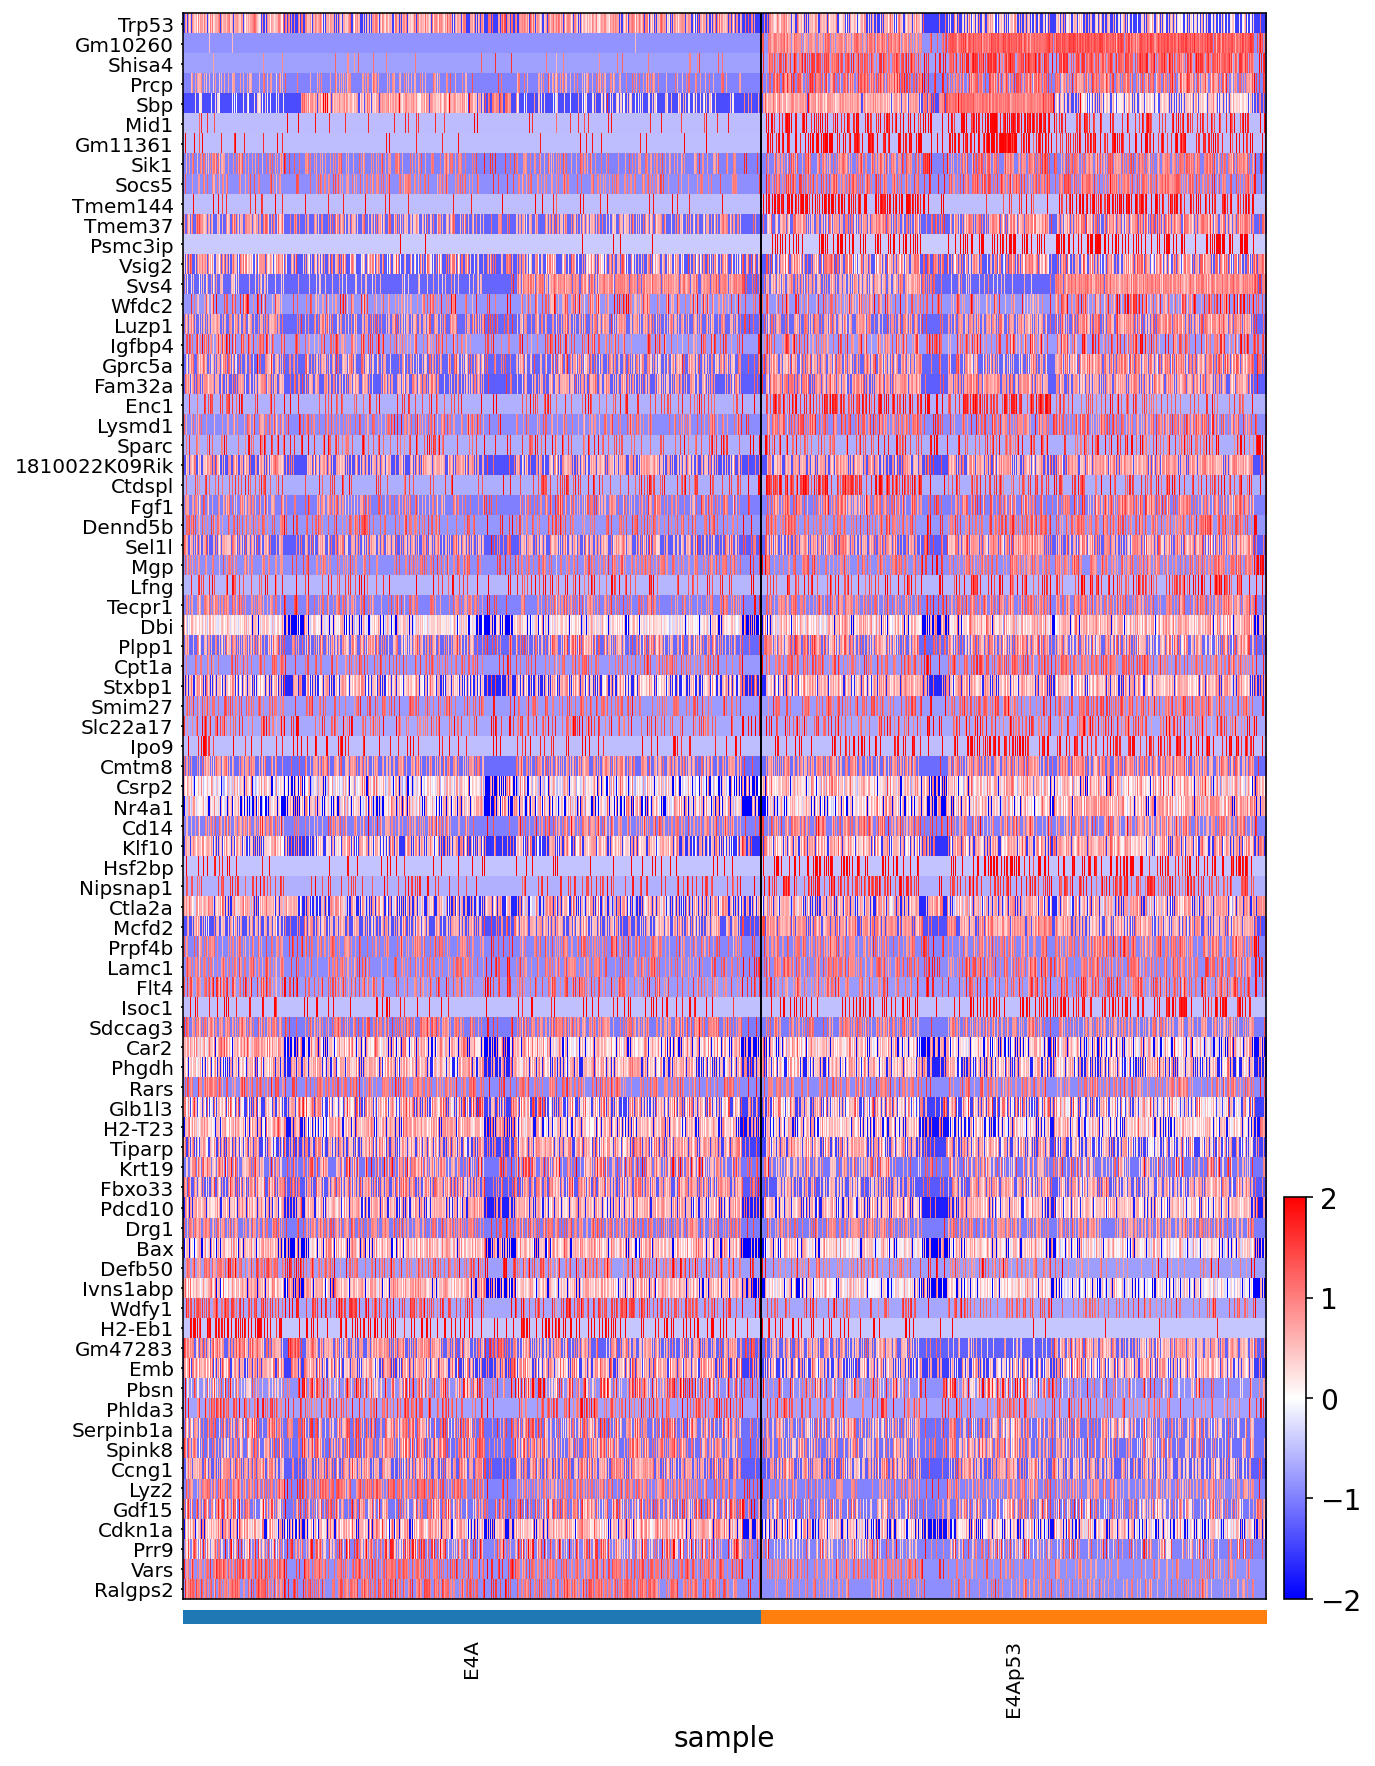

In [207]:
plt.rcParams.update({'font.size': 12})
sc.pl.heatmap(E4A_E4Ap53_2weeks_Luminal_1, genes, groupby='sample', 
              use_raw=False,
              #cmap = mycolormap_2,
              vmin=-2, vmax=2, show_gene_labels= True,
              cmap='bwr', dendrogram=False, swap_axes=True, 
              save = "Luminal_imputation_E4A_E4Ap53_2weeks_luminal_1_fcHurdleSig.pdf")

#### Gene set analysis 

In [208]:
fcHurdle

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
1,p00001,0.503119,-0.039023,0.097103,-0.175149,0.831271
2,p00002,0.001587,-0.002216,0.437736,-0.442168,0.044133
3,p00003,0.439676,NaN,NaN,NaN,0.801030
4,p00005,0.166147,0.157309,0.373766,-0.059149,0.627116
5,p00009,0.550989,-0.246789,0.193956,-0.687535,0.865474
...,...,...,...,...,...,...
16910,p19849,0.273720,NaN,NaN,NaN,0.738221
16911,p19851,0.284013,0.024314,0.088207,-0.039580,0.738221
16912,p19852,0.375948,0.211901,0.562950,-0.139148,0.801030
16913,p19853,0.576878,-0.153676,0.291086,-0.598438,0.884251


In [209]:
%%R -o fcHurdle_genes
library(data.table)
fcHurdle_genes <- merge(fcHurdle, as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdle_genes, fdr)

#### -log(p-value) * sign(logFC)

In [210]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * np.sign(fcHurdle_genes['coef'])
fcHurdle_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,5.377439e-249,7.667617,7.973713,7.361522,9.095400e-245,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,244.041178
2,p13789,4.632088e-186,NaN,NaN,NaN,3.917357e-182,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,NaN
3,p00729,7.242240e-141,4.954957,5.363805,4.546110,4.083175e-137,Shisa4,6969,0,0.105110,0.846595,1.590078,0.105110,0.298304,136.389002
4,p18333,4.753730e-75,NaN,NaN,NaN,2.010115e-71,BC023719,2980,0,0.031847,0.665552,-1.284648,0.031847,0.145588,NaN
5,p08726,9.314351e-62,3.242205,3.717235,2.767174,3.150859e-58,Prcp,9425,0,0.153184,0.898269,2.282486,0.153184,0.370946,57.501571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16910,p19774,9.483488e-01,-0.000224,0.134934,-0.135382,1.000000e+00,Rpl13a-ps1,2405,0,0.028179,0.786294,0.038832,0.028179,0.148852,0.000000
16911,p19781,9.868509e-01,-0.000812,0.071339,-0.072963,1.000000e+00,4833407H14Rik,554,0,0.008795,1.041433,1.619097,0.008795,0.095706,0.000000
16912,p19784,9.858240e-01,0.031435,0.443082,-0.380211,1.000000e+00,Smc3,14167,0,0.196735,0.695691,-0.046959,0.196735,0.369955,-0.000000
16913,p19814,9.538031e-01,0.015887,0.145408,-0.113634,1.000000e+00,Pnliprp1,1057,1,0.019432,1.373059,5.593582,0.019432,0.163343,-0.000000


In [211]:
fcHurdle_genes.sort_values(by=['coef'])
fcHurdle_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,5.377439e-249,7.667617,7.973713,7.361522,9.095400e-245,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,244.041178
2,p13789,4.632088e-186,NaN,NaN,NaN,3.917357e-182,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,NaN
3,p00729,7.242240e-141,4.954957,5.363805,4.546110,4.083175e-137,Shisa4,6969,0,0.105110,0.846595,1.590078,0.105110,0.298304,136.389002
4,p18333,4.753730e-75,NaN,NaN,NaN,2.010115e-71,BC023719,2980,0,0.031847,0.665552,-1.284648,0.031847,0.145588,NaN
5,p08726,9.314351e-62,3.242205,3.717235,2.767174,3.150859e-58,Prcp,9425,0,0.153184,0.898269,2.282486,0.153184,0.370946,57.501571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16910,p19774,9.483488e-01,-0.000224,0.134934,-0.135382,1.000000e+00,Rpl13a-ps1,2405,0,0.028179,0.786294,0.038832,0.028179,0.148852,0.000000
16911,p19781,9.868509e-01,-0.000812,0.071339,-0.072963,1.000000e+00,4833407H14Rik,554,0,0.008795,1.041433,1.619097,0.008795,0.095706,0.000000
16912,p19784,9.858240e-01,0.031435,0.443082,-0.380211,1.000000e+00,Smc3,14167,0,0.196735,0.695691,-0.046959,0.196735,0.369955,-0.000000
16913,p19814,9.538031e-01,0.015887,0.145408,-0.113634,1.000000e+00,Pnliprp1,1057,1,0.019432,1.373059,5.593582,0.019432,0.163343,-0.000000


In [212]:
fcHurdle_genes[fcHurdle_genes['coef'].isnull().values]

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
2,p13789,4.632088e-186,NaN,NaN,NaN,3.917357e-182,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,NaN
4,p18333,4.753730e-75,NaN,NaN,NaN,2.010115e-71,BC023719,2980,0,0.031847,0.665552,-1.284648,0.031847,0.145588,NaN
69,p18336,1.476964e-09,NaN,NaN,NaN,3.661151e-07,Gm8909,329,0,0.003835,0.913366,0.722349,0.003835,0.059180,NaN
250,p04863,4.191558e-05,NaN,NaN,NaN,2.824542e-03,Trabd2b,1403,0,0.022194,0.937296,1.391441,0.022194,0.144229,NaN
251,p18337,4.185254e-05,NaN,NaN,NaN,2.824542e-03,Gm20478,204,0,0.001862,0.628692,-1.626401,0.001862,0.034211,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,p16986,1.000000e+00,NaN,NaN,NaN,1.000000e+00,Wnt10b,243,0,0.003923,0.979648,1.306622,0.003923,0.061992,NaN
16732,p17564,9.099712e-01,NaN,NaN,NaN,1.000000e+00,Dppa2,76,0,0.000983,0.845786,0.064905,0.000983,0.028827,NaN
16753,p17959,9.097442e-01,NaN,NaN,NaN,1.000000e+00,Syngr3,94,0,0.001395,0.893684,0.441418,0.001395,0.035309,NaN
16789,p18488,1.000000e+00,NaN,NaN,NaN,1.000000e+00,Kcnh8,42,0,0.000713,1.120434,2.012821,0.000713,0.028259,NaN


In [213]:
fcHurdle_genes.iloc[1, 2]

nan

In [214]:
fcHurdle_genes['coef'][1] = -1.0

<ipython-input-214-d414701a3b31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcHurdle_genes['coef'][1] = -1.0


In [215]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * np.sign(fcHurdle_genes['coef'])
fcHurdle_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,5.377439e-249,7.667617,7.973713,7.361522,9.095400e-245,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,244.041178
2,p13789,4.632088e-186,-1.000000,NaN,NaN,3.917357e-182,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,-181.407007
3,p00729,7.242240e-141,4.954957,5.363805,4.546110,4.083175e-137,Shisa4,6969,0,0.105110,0.846595,1.590078,0.105110,0.298304,136.389002
4,p18333,4.753730e-75,NaN,NaN,NaN,2.010115e-71,BC023719,2980,0,0.031847,0.665552,-1.284648,0.031847,0.145588,NaN
5,p08726,9.314351e-62,3.242205,3.717235,2.767174,3.150859e-58,Prcp,9425,0,0.153184,0.898269,2.282486,0.153184,0.370946,57.501571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16910,p19774,9.483488e-01,-0.000224,0.134934,-0.135382,1.000000e+00,Rpl13a-ps1,2405,0,0.028179,0.786294,0.038832,0.028179,0.148852,0.000000
16911,p19781,9.868509e-01,-0.000812,0.071339,-0.072963,1.000000e+00,4833407H14Rik,554,0,0.008795,1.041433,1.619097,0.008795,0.095706,0.000000
16912,p19784,9.858240e-01,0.031435,0.443082,-0.380211,1.000000e+00,Smc3,14167,0,0.196735,0.695691,-0.046959,0.196735,0.369955,-0.000000
16913,p19814,9.538031e-01,0.015887,0.145408,-0.113634,1.000000e+00,Pnliprp1,1057,1,0.019432,1.373059,5.593582,0.019432,0.163343,-0.000000


In [216]:
fcHurdle_genes.to_csv('./MAST/E4A_E4Ap53_2weeks_luminal_1/fcHurdle_genes.csv')

#### GSEA

In [231]:
%%R
head(fcHurdle)

  primerid  Pr(>Chisq)         coef      ci.hi       ci.lo        fdr
1   p00001 0.503118642 -0.039022957 0.09710271 -0.17514863 0.83127127
2   p00002 0.001586727 -0.002216436 0.43773560 -0.44216847 0.04413278
3   p00003 0.439676168          NaN        NaN         NaN 0.80102995
4   p00005 0.166147122  0.157308539 0.37376626 -0.05914918 0.62711551
5   p00009 0.550988819 -0.246789427 0.19395643 -0.68753528 0.86547408
6   p00010 0.104681286  0.224659465 0.67428846 -0.22496953 0.53722986


In [232]:
%%R -o fcHurdle
library(data.table)
fcHurdle <- merge(fcHurdle, as.data.table(mcols(sca)), by='primerid')
head(fcHurdle)

  primerid  Pr(>Chisq)         coef      ci.hi       ci.lo        fdr gene_id
1   p00001 0.503118642 -0.039022957 0.09710271 -0.17514863 0.83127127   hETV4
2   p00002 0.001586727 -0.002216436 0.43773560 -0.44216847 0.04413278    EGFP
3   p00003 0.439676168          NaN        NaN         NaN 0.80102995 CreERT2
4   p00005 0.166147122  0.157308539 0.37376626 -0.05914918 0.62711551   hETV4
5   p00009 0.550988819 -0.246789427 0.19395643 -0.68753528 0.86547408  Mrpl15
6   p00010 0.104681286  0.224659465 0.67428846 -0.22496953 0.53722986  Lypla1
  n_cells highly_variable       means dispersions dispersions_norm        mean
1    9304               1 0.245906325   1.4271647        8.1253099 0.245906325
2   10407               0 0.153405170   0.8349393        1.4996085 0.153405170
3     163               0 0.003174699   1.2363847        3.4107995 0.003174699
4     720               0 0.010206114   1.1866987        3.1457226 0.010206114
5   11394               0 0.135865078   0.6261008       -1.

In [233]:
%%R
minim <- min(fcHurdle[fcHurdle$`fdr` > 0]$`fdr`)

In [234]:
%%R
head(fcHurdle[,FCtimesp := -log10(`fdr`+ minim) * sign(`coef`)])

  primerid  Pr(>Chisq)         coef      ci.hi       ci.lo        fdr gene_id
1   p00001 0.503118642 -0.039022957 0.09710271 -0.17514863 0.83127127   hETV4
2   p00002 0.001586727 -0.002216436 0.43773560 -0.44216847 0.04413278    EGFP
3   p00003 0.439676168          NaN        NaN         NaN 0.80102995 CreERT2
4   p00005 0.166147122  0.157308539 0.37376626 -0.05914918 0.62711551   hETV4
5   p00009 0.550988819 -0.246789427 0.19395643 -0.68753528 0.86547408  Mrpl15
6   p00010 0.104681286  0.224659465 0.67428846 -0.22496953 0.53722986  Lypla1
  n_cells highly_variable       means dispersions dispersions_norm        mean
1    9304               1 0.245906325   1.4271647        8.1253099 0.245906325
2   10407               0 0.153405170   0.8349393        1.4996085 0.153405170
3     163               0 0.003174699   1.2363847        3.4107995 0.003174699
4     720               0 0.010206114   1.1866987        3.1457226 0.010206114
5   11394               0 0.135865078   0.6261008       -1.

In [235]:
%%R -o fcHurdleluminal_2w
fcHurdleluminal_2w <- fcHurdle

In [237]:
fcHurdleluminal_2w

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,FCtimesp
1,p00001,0.503119,-0.039023,0.097103,-0.175149,0.831271,hETV4,9304,1,0.245906,1.427165,8.125310,0.245906,0.592409,-0.080257
2,p00002,0.001587,-0.002216,0.437736,-0.442168,0.044133,EGFP,10407,0,0.153405,0.834939,1.499609,0.153405,0.357888,-1.355239
3,p00003,0.439676,NaN,NaN,NaN,0.801030,CreERT2,163,0,0.003175,1.236385,3.410800,0.003175,0.062651,NaN
4,p00005,0.166147,0.157309,0.373766,-0.059149,0.627116,hETV4,720,0,0.010206,1.186699,3.145723,0.010206,0.110053,0.202652
5,p00009,0.550989,-0.246789,0.193956,-0.687535,0.865474,Mrpl15,11394,0,0.135865,0.626101,-1.082051,0.135865,0.291659,-0.062746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16910,p19849,0.273720,NaN,NaN,NaN,0.738221,AC125149.3,186,0,0.002363,0.856138,0.204154,0.002363,0.044982,NaN
16911,p19851,0.284013,0.024314,0.088207,-0.039580,0.738221,AC168977.1,167,0,0.001918,0.858370,0.165852,0.001918,0.040580,0.131814
16912,p19852,0.375948,0.211901,0.562950,-0.139148,0.801030,AC149090.1,7544,0,0.114098,0.929673,2.726850,0.114098,0.325690,0.096351
16913,p19853,0.576878,-0.153676,0.291086,-0.598438,0.884251,CAAA01118383.1,12212,0,0.158647,0.676830,-0.454938,0.158647,0.327685,-0.053425


In [241]:
#2 weeks : ETV4p53 vs ETV4
fcHurdleluminal_2w[fcHurdleluminal_2w['gene_id']=='Cdkn1a']

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,FCtimesp
15378,p18107,3.161616e-24,-2.17905,-1.691361,-2.666738,3.342224e-21,Cdkn1a,35588,0,1.080477,0.760378,1.272177,1.080477,0.906405,-20.475965


In [242]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

In [243]:
fcHurdleluminal_2w.sort_values(by=['FCtimesp'], inplace = True)

In [245]:
fcHurdleluminal_2w.iloc[:10]

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,FCtimesp
706,p00839,7.701959e-40,-2.908325,-2.533694,-3.282957,1.447455e-36,Ralgps2,8237,0,0.112279,0.765286,0.477497,0.112279,0.293130,-35.839395
15454,p18197,2.960227e-39,-0.614681,-0.523746,-0.705616,5.006928e-36,Rps18,49378,0,3.052159,0.167546,-2.297194,3.052159,0.715106,-35.300429
15507,p18255,5.827532e-31,-2.513170,-2.140420,-2.885920,8.213906e-28,Vars,11384,0,0.152020,0.723303,0.119562,0.152020,0.331597,-27.085450
657,p00786,5.890149e-27,-1.368791,-1.007721,-1.729862,6.641732e-24,Ivns1abp,20868,0,0.351447,0.732121,0.798631,0.351447,0.507250,-23.177719
15378,p18107,3.161616e-24,-2.179050,-1.691361,-2.666738,3.342224e-21,Cdkn1a,35588,0,1.080477,0.760378,1.272177,1.080477,0.906405,-20.475965
15476,p18221,7.211853e-22,-1.383781,-1.164212,-1.603350,6.420067e-19,H2-Eb1,9340,1,0.360963,2.985005,24.547014,0.360963,1.038016,-18.192460
8600,p10146,6.056776e-17,-1.812169,-1.395517,-2.228821,4.454100e-14,Lyz2,11588,1,0.459811,3.103051,15.377114,0.459811,1.194494,-13.351240
3244,p03793,2.612816e-14,-2.337354,-1.764756,-2.909952,1.699737e-11,Prr9,9353,1,0.275940,2.195841,16.228182,0.275940,0.778409,-10.769618
621,p00734,3.081970e-14,-1.684045,-1.312576,-2.055515,1.930683e-11,Phlda3,15783,0,0.305465,0.907579,2.648184,0.305465,0.526529,-10.714289
7213,p08444,1.139000e-13,-1.176971,-0.776055,-1.577887,6.880371e-11,Bax,25461,0,0.434424,0.618613,0.418625,0.434424,0.518401,-10.162388


In [246]:
rankfile = fcHurdleluminal_2w[['gene_id','FCtimesp']]

In [247]:
#rankfile['FCtimesp'] = rankfile['FCtimesp']*(-1)
rankfile.sort_values(by=['FCtimesp'], inplace = True)
rankfile

/home/dan/miniconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,gene_id,FCtimesp
706,Ralgps2,-35.839395
15454,Rps18,-35.300429
15507,Vars,-27.085450
657,Ivns1abp,-23.177719
15378,Cdkn1a,-20.475965
...,...,...
16892,Emx2,NaN
16893,2700089I24Rik,NaN
16894,Gm17203,NaN
16909,Csprs,NaN


In [248]:
rankfile['gene_id'] = rankfile['gene_id'].str.upper()
rankfile['gene_id']

<ipython-input-248-498705786604>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankfile['gene_id'] = rankfile['gene_id'].str.upper()


706            RALGPS2
15454            RPS18
15507             VARS
657           IVNS1ABP
15378           CDKN1A
             ...      
16892             EMX2
16893    2700089I24RIK
16894          GM17203
16909            CSPRS
16910       AC125149.3
Name: gene_id, Length: 16914, dtype: object

In [249]:
import os, sys
import gseapy as gp
gmtfiles = os.listdir('./GSEA/gmt')

for i in gmtfiles:
    gp.prerank(rnk=rankfile,gene_sets= './GSEA/gmt/'+i,
               processes=12,min_size=10,max_size=19855,
               permutation_num=100, 
               outdir='GSEA/E4A_E4Ap53_2weeks_luminal_1/'+i, format='pdf', seed=6)

2022-02-24 11:16:16,051 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 11:16:16,095 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 11:20:18,869 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 11:20:18,913 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 11:23:35,062 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 11:23:35,104 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 11:23:46,668 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 11:23:46,709 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 11:24:00,367 Input gene rankings contains NA values(gene name and ranking value), drop them a

#### 4 months

#### select out only ETV4AAA+ and ETV4AAA+p53- cells from luminal 1

In [250]:
adata_normalized_CPM_log2.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 7.387303 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 7.0420675, 7.0420675, ..., 0.       , 8.619714 ,
        0.       ]], dtype=float32)

In [251]:
E4Ap53_4months = adata_normalized_CPM_log2[adata_normalized_CPM_log2.obs['genotype_age'].isin(['E4Ap53_4months'])]
E4Ap53_4months.X

ArrayView([[ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 6.9302983,  0.       ,  0.       , ...,  0.       ,
             0.       ,  6.9302983],
           [11.019023 ,  7.9367642,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           ...,
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 0.       ,  7.387303 ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 0.       ,  7.0420675,  7.0420675, ...,  0.       ,
             8.619714 ,  0.       ]], dtype=float32)

In [252]:
np.sum(E4Ap53_4months.var['gene_id'] == 'Trp53')

1

In [253]:
E4Ap53_4months.layers['counts']

ArrayView([[ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 6.9302983,  0.       ,  0.       , ...,  0.       ,
             0.       ,  6.9302983],
           [11.019023 ,  7.9367642,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           ...,
           [ 0.       ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 0.       ,  7.387303 ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 0.       ,  7.0420675,  7.0420675, ...,  0.       ,
             8.619714 ,  0.       ]], dtype=float32)

In [254]:
p53is0 = np.asarray(E4Ap53_4months.layers['counts'][:,E4Ap53_4months.var['gene_id'] == 'Trp53'] == 0.0)

In [255]:
p53is0.shape

(7094, 1)

In [256]:
p53is0

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [257]:
np.sum(p53is0)

4632

In [258]:
E4A_4months = adata_normalized_CPM_log2[adata_normalized_CPM_log2.obs['genotype_age'].isin(['E4A_4months'])]
E4A_4months.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AAACCTGAGTGAAGTT,E4A,4months,1,E4A_4months,1478.0,7.318540,684,0.019894,0.0,4.855418e-55,0.085922,-0.081790,S,Fibroblasts_3
AAACCTGCAAGGACTG,E4A,4months,1,E4A_4months,3107.0,8.071531,720,0.029669,0.0,1.090523e-68,-0.010508,0.031411,G2M,T_cells_2
AAACCTGCACAGACAG,E4A,4months,1,E4A_4months,1454.0,7.321850,670,0.038995,0.0,4.855418e-55,-0.023617,-0.026895,G1,Fibroblasts_3
AAACGGGCAGTATCTG,E4A,4months,1,E4A_4months,5047.0,8.545003,1477,0.018284,0.0,1.587134e-25,-0.027302,-0.027867,G1,Fibroblasts_1
AAACGGGTCTAACTCT,E4A,4months,1,E4A_4months,2975.0,8.140024,1567,0.132108,0.0,2.132098e-01,-0.032340,-0.073641,G1,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGCTGTTCCAAACTG,E4A,4months,3,E4A_4months,7066.0,8.884888,1565,0.021601,0.0,2.768376e-34,0.021365,-0.084871,S,Macrophage_1
CTGATCCTCGTCTGCT-1,E4A,4months,3,E4A_4months,8998.0,9.111514,1556,0.006734,0.0,5.535565e-02,0.005096,-0.089914,S,Dendritic_cells
GCGCAACAGGGTCTCC,E4A,4months,3,E4A_4months,9196.0,9.134646,1712,0.008090,0.0,5.535565e-02,-0.015034,-0.083869,G1,Dendritic_cells
TAAACCGCACTTCTGC,E4A,4months,3,E4A_4months,8941.0,9.098515,1447,0.000112,0.0,2.452460e+01,0.025603,-0.057727,S,Luminal_3


In [259]:
E4A_4months.obs['sample']

AAACCTGAGTGAAGTT      E4A
AAACCTGCAAGGACTG      E4A
AAACCTGCACAGACAG      E4A
AAACGGGCAGTATCTG      E4A
AAACGGGTCTAACTCT      E4A
                     ... 
CTGCTGTTCCAAACTG      E4A
CTGATCCTCGTCTGCT-1    E4A
GCGCAACAGGGTCTCC      E4A
TAAACCGCACTTCTGC      E4A
GGTGCGTCACTAAGTC      E4A
Name: sample, Length: 5947, dtype: category
Categories (1, object): ['E4A']

In [260]:
p53is0[:,0]

array([ True,  True,  True, ...,  True,  True,  True])

In [261]:
np.ones_like(E4A_4months.obs['sample'], dtype=bool).shape

(5947,)

In [262]:
# 6603 E4A_2weeks samples, 5842 E4Ap53_2weeks samples, of which 3143 samples p53 does not express.
ids = np.concatenate((np.ones_like(E4A_4months.obs['sample'], dtype=bool), p53is0[:,0]))
ids.shape

(13041,)

In [263]:
ids.shape

(13041,)

In [264]:
E4A_E4Ap53_4months = adata_normalized_CPM_log2[adata_normalized_CPM_log2.obs['genotype_age'].isin(['E4A_4months', 'E4Ap53_4months'])]
E4A_E4Ap53_4months.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AAACCTGAGTGAAGTT,E4A,4months,1,E4A_4months,1478.0,7.318540,684,0.019894,0.0,4.855418e-55,0.085922,-0.081790,S,Fibroblasts_3
AAACCTGCAAGGACTG,E4A,4months,1,E4A_4months,3107.0,8.071531,720,0.029669,0.0,1.090523e-68,-0.010508,0.031411,G2M,T_cells_2
AAACCTGCACAGACAG,E4A,4months,1,E4A_4months,1454.0,7.321850,670,0.038995,0.0,4.855418e-55,-0.023617,-0.026895,G1,Fibroblasts_3
AAACGGGCAGTATCTG,E4A,4months,1,E4A_4months,5047.0,8.545003,1477,0.018284,0.0,1.587134e-25,-0.027302,-0.027867,G1,Fibroblasts_1
AAACGGGTCTAACTCT,E4A,4months,1,E4A_4months,2975.0,8.140024,1567,0.132108,0.0,2.132098e-01,-0.032340,-0.073641,G1,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCGTCAGTAGAGTGC,E4Ap53,4months,3,E4Ap53_4months,8311.0,9.038959,2002,0.012938,0.0,1.286236e-02,-0.036352,-0.061798,G1,Macrophage_2
ATCCGAAAGGTGTGGT-1,E4Ap53,4months,3,E4Ap53_4months,6088.0,8.810460,1063,0.091885,0.0,5.653162e+00,0.041644,-0.104738,S,Seminal_vesicle_1
CCCAGTTAGGTACTCT,E4Ap53,4months,3,E4Ap53_4months,7895.0,9.002332,1357,0.027826,0.0,7.421237e+00,-0.028125,-0.104002,G1,Seminal_vesicle_1
TGCGTGGAGTGGTCCC,E4Ap53,4months,3,E4Ap53_4months,6009.0,8.826881,2361,0.118269,0.0,1.392403e-01,-0.060195,-0.007737,G1,Luminal_4


In [265]:
ids.shape

(13041,)

In [266]:
np.sum(ids)

10579

In [267]:
# 6603 + 3143 = 9746 samples
E4A_E4Ap53_4months_filtered = E4A_E4Ap53_4months[ids]
E4A_E4Ap53_4months_filtered.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AAACCTGAGTGAAGTT,E4A,4months,1,E4A_4months,1478.0,7.318540,684,0.019894,0.0,4.855418e-55,0.085922,-0.081790,S,Fibroblasts_3
AAACCTGCAAGGACTG,E4A,4months,1,E4A_4months,3107.0,8.071531,720,0.029669,0.0,1.090523e-68,-0.010508,0.031411,G2M,T_cells_2
AAACCTGCACAGACAG,E4A,4months,1,E4A_4months,1454.0,7.321850,670,0.038995,0.0,4.855418e-55,-0.023617,-0.026895,G1,Fibroblasts_3
AAACGGGCAGTATCTG,E4A,4months,1,E4A_4months,5047.0,8.545003,1477,0.018284,0.0,1.587134e-25,-0.027302,-0.027867,G1,Fibroblasts_1
AAACGGGTCTAACTCT,E4A,4months,1,E4A_4months,2975.0,8.140024,1567,0.132108,0.0,2.132098e-01,-0.032340,-0.073641,G1,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCGTCAGTAGAGTGC,E4Ap53,4months,3,E4Ap53_4months,8311.0,9.038959,2002,0.012938,0.0,1.286236e-02,-0.036352,-0.061798,G1,Macrophage_2
ATCCGAAAGGTGTGGT-1,E4Ap53,4months,3,E4Ap53_4months,6088.0,8.810460,1063,0.091885,0.0,5.653162e+00,0.041644,-0.104738,S,Seminal_vesicle_1
CCCAGTTAGGTACTCT,E4Ap53,4months,3,E4Ap53_4months,7895.0,9.002332,1357,0.027826,0.0,7.421237e+00,-0.028125,-0.104002,G1,Seminal_vesicle_1
TGCGTGGAGTGGTCCC,E4Ap53,4months,3,E4Ap53_4months,6009.0,8.826881,2361,0.118269,0.0,1.392403e-01,-0.060195,-0.007737,G1,Luminal_4


In [268]:
E4A_E4Ap53_4months_filtered.X.shape

(10579, 19854)

In [269]:
E4A_E4Ap53_4months_Luminal_1 = E4A_E4Ap53_4months_filtered[E4A_E4Ap53_4months_filtered.obs['leiden_r1'].isin(['Luminal_1'])]
E4A_E4Ap53_4months_Luminal_1.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AAACGGGTCTAACTCT,E4A,4months,1,E4A_4months,2975.0,8.140024,1567,0.132108,0.0,2.132098e-01,-0.032340,-0.073641,G1,Luminal_1
AGGCCACCACAAGTAA,E4A,4months,1,E4A_4months,3297.0,8.216088,1430,0.108919,0.0,2.132098e-01,-0.030424,-0.006364,G1,Luminal_1
CCTCAGTTCACAGGCC,E4A,4months,1,E4A_4months,2945.0,8.107720,1286,0.112651,0.0,2.146802e-14,-0.054220,-0.130226,G1,Luminal_1
CCTTTCTGTCATTAGC,E4A,4months,1,E4A_4months,3858.0,8.324821,1643,0.064727,0.0,2.146802e-14,-0.020528,0.016276,G2M,Luminal_1
CTCCTAGAGCTCCCAG,E4A,4months,1,E4A_4months,2843.0,8.066208,1253,0.107064,0.0,2.146802e-14,0.019714,-0.019268,S,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACTCCAAGTGCGATG,E4Ap53,4months,3,E4Ap53_4months,6311.0,8.772301,2009,0.022005,0.0,2.132098e-01,0.009932,0.007942,S,Luminal_1
ATTGGTGAGTACGACG,E4Ap53,4months,3,E4Ap53_4months,7190.0,8.897408,2466,0.016819,0.0,2.132098e-01,0.006027,-0.083847,S,Luminal_1
CAGCGACGTAGGCATG,E4Ap53,4months,3,E4Ap53_4months,8137.0,9.025095,2443,0.020700,0.0,2.132098e-01,0.001049,-0.012599,S,Luminal_1
TCACGAAAGACGACGT,E4Ap53,4months,3,E4Ap53_4months,8538.0,9.069122,2829,0.016699,0.0,1.247783e+01,0.029170,-0.079947,S,Luminal_1


In [270]:
# the transposed matrix with columns cells and rows genes
# log-normalized no scaled data in adata.raw and adata_test
from scipy.sparse import csr_matrix
csr_matrix = csr_matrix(E4A_E4Ap53_4months_Luminal_1.X.T)

In [271]:
%%R -i csr_matrix
library(MAST)
class(csr_matrix)

[1] "dgRMatrix"
attr(,"package")
[1] "Matrix"


In [272]:
%%R
str(csr_matrix)

Formal class 'dgRMatrix' [package "Matrix"] with 6 slots
  ..@ p       : int [1:19855] 0 897 1656 1659 1660 1787 1787 1787 1788 2227 ...
  ..@ j       : int [1:3192962] 0 1 2 3 5 7 8 9 10 11 ...
  ..@ Dim     : int [1:2] 19854 915
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:3192962] 10.72 8.25 9.99 9.6 10.43 ...
  ..@ factors : list()


In [273]:
E4A_E4Ap53_4months_Luminal_1.obs.index.name

In [274]:
E4A_E4Ap53_4months_Luminal_1.obs.index.name = 'cells'

In [275]:
E4A_E4Ap53_4months_Luminal_1.obs['leiden_r1']

cells
AAACGGGTCTAACTCT    Luminal_1
AGGCCACCACAAGTAA    Luminal_1
CCTCAGTTCACAGGCC    Luminal_1
CCTTTCTGTCATTAGC    Luminal_1
CTCCTAGAGCTCCCAG    Luminal_1
                      ...    
CACTCCAAGTGCGATG    Luminal_1
ATTGGTGAGTACGACG    Luminal_1
CAGCGACGTAGGCATG    Luminal_1
TCACGAAAGACGACGT    Luminal_1
GCAATCAAGGCCCTTG    Luminal_1
Name: leiden_r1, Length: 915, dtype: category
Categories (1, object): ['Luminal_1']

In [276]:
# cell data 48926 rows
cData = E4A_E4Ap53_4months_Luminal_1.obs

In [277]:
%%R -i cData
str(cData)

'data.frame':	915 obs. of  14 variables:
 $ sample       : Factor w/ 2 levels "E4A","E4Ap53": 1 1 1 1 1 1 1 1 1 1 ...
 $ age          : Factor w/ 1 level "4months": 1 1 1 1 1 1 1 1 1 1 ...
 $ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ genotype_age : Factor w/ 2 levels "E4A_4months",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ n_counts     : num  2975 3297 2945 3858 2843 ...
 $ log_counts   : num  8.14 8.22 8.11 8.32 8.07 ...
 $ n_genes      : int  1567 1430 1286 1643 1253 1411 905 2455 1701 1845 ...
 $ mt_frac      : num  0.1321 0.1089 0.1127 0.0647 0.1071 ...
 $ doublet      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ doublet_score: num  2.13e-01 2.13e-01 2.15e-14 2.15e-14 2.15e-14 ...
 $ S_score      : num  -0.0323 -0.0304 -0.0542 -0.0205 0.0197 ...
 $ G2M_score    : num  -0.07364 -0.00636 -0.13023 0.01628 -0.01927 ...
 $ phase        : Factor w/ 3 levels "G1","G2M","S": 1 1 1 2 3 1 1 3 1 2 ...
 $ leiden_r1    : Factor w/ 1 level "Luminal_1": 1 1 1 1 1 1 1 1 1 1 ...


In [278]:
E4A_E4Ap53_4months_Luminal_1.obs['leiden_r1']

cells
AAACGGGTCTAACTCT    Luminal_1
AGGCCACCACAAGTAA    Luminal_1
CCTCAGTTCACAGGCC    Luminal_1
CCTTTCTGTCATTAGC    Luminal_1
CTCCTAGAGCTCCCAG    Luminal_1
                      ...    
CACTCCAAGTGCGATG    Luminal_1
ATTGGTGAGTACGACG    Luminal_1
CAGCGACGTAGGCATG    Luminal_1
TCACGAAAGACGACGT    Luminal_1
GCAATCAAGGCCCTTG    Luminal_1
Name: leiden_r1, Length: 915, dtype: category
Categories (1, object): ['Luminal_1']

In [279]:
# 19854 genes
fData = E4A_E4Ap53_4months_Luminal_1.var

In [280]:
%%R -i fData
str(fData)

'data.frame':	19854 obs. of  8 variables:
 $ gene_id         : Factor w/ 19853 levels "0610005C13Rik",..: 19853 5208 4167 5209 19853 19169 15232 16666 11840 11139 ...
 $ n_cells         : int  9304 10407 163 6591 720 18 16 832 11394 9614 ...
 $ highly_variable : logi  TRUE FALSE FALSE TRUE FALSE FALSE ...
 $ means           : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ dispersions     : num  1.427 0.835 1.236 2.531 1.187 ...
 $ dispersions_norm: num  8.13 1.5 3.41 19.76 3.15 ...
 $ mean            : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ std             : num  0.5924 0.3579 0.0627 0.8143 0.1101 ...


In [281]:
%%R
E4A_E4Ap53_4months_Luminal_1_sca <- MAST::FromMatrix(
    as.matrix(csr_matrix), 
    cData,
    fData,
    class = "SingleCellAssay"
)

In [210]:
%%R
save(E4A_E4Ap53_4months_Luminal_1_sca, file=paste0("./E4A_E4Ap53_4months_Luminal_1_sca", Sys.Date(),".rda"))

In [282]:
%%R
load("2022-02-23.rda")

In [283]:
%%R
head(sca)

class: SingleCellAssay 
dim: 6 48926 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(48926): wk00001 wk00002 ... wk48925 wk48926
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [284]:
%%R
# sca columns cells and rows genes
library(MAST)
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [285]:
%%R
# sca columns cells and rows genes
length(rowData(sca)$gene_id)

[1] 19854


#### Differential Expression using a Hurdle model 

In [286]:
%%R
head(colData(E4A_E4Ap53_4months_Luminal_1_sca)$n_genes)

[1] 1567 1430 1286 1643 1253 1411


In [287]:
%%R
levels(droplevels(colData(E4A_E4Ap53_4months_Luminal_1_sca)$sample))

[1] "E4A"    "E4Ap53"


In [288]:
%%R
levels(colData(E4A_E4Ap53_4months_Luminal_1_sca)$sample)

[1] "E4A"    "E4Ap53"


In [289]:
%%R
str(colData(E4A_E4Ap53_4months_Luminal_1_sca))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:915] "wk001" "wk002" "wk003" "wk004" ...
  ..@ nrows          : int 915
  ..@ listData       :List of 15
  .. ..$ sample       : Factor w/ 2 levels "E4A","E4Ap53": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ age          : Factor w/ 1 level "4months": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 2 levels "E4A_4months",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ n_counts     : num [1:915] 2975 3297 2945 3858 2843 ...
  .. ..$ log_counts   : num [1:915] 8.14 8.22 8.11 8.32 8.07 ...
  .. ..$ n_genes      : int [1:915] 1567 1430 1286 1643 1253 1411 905 2455 1701 1845 ...
  .. ..$ mt_frac      : num [1:915] 0.1321 0.1089 0.1127 0.0647 0.1071 ...
  .. ..$ doublet      : num [1:915] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ doublet_score: num [1:915] 2.13e-01 2.13e-01 2.15e-14 2.15e-14 2.15e-14 ...
  .. ..$ S_score      : num [1:915] -0.0323 

In [290]:
%%R
head(colData(E4A_E4Ap53_4months_Luminal_1_sca)$n_genes)

[1] 1567 1430 1286 1643 1253 1411


In [291]:
%%R
print("Dimensions before subsetting:")
print(dim(E4A_E4Ap53_4months_Luminal_1_sca))
# filter out the not expressed genes
E4A_E4Ap53_4months_Luminal_1_sca_filt = E4A_E4Ap53_4months_Luminal_1_sca[rowSums(assay(E4A_E4Ap53_4months_Luminal_1_sca)) != 0, ]
print("Dimensions after subsetting:")
print(dim(E4A_E4Ap53_4months_Luminal_1_sca_filt))

[1] "Dimensions before subsetting:"
[1] 19854   915
[1] "Dimensions after subsetting:"
[1] 16601   915


In [221]:
%%R
save(E4A_E4Ap53_4months_Luminal_1_sca_filt, file="./MAST/E4A_E4Ap53_4months_Luminal_1_sca_filt.rda")

In [292]:
%%R
colData(E4A_E4Ap53_4months_Luminal_1_sca_filt)$n_genes = scale(colData(E4A_E4Ap53_4months_Luminal_1_sca_filt)$n_genes)

In [293]:
%%R
mean(colData(E4A_E4Ap53_4months_Luminal_1_sca_filt)$n_genes)

[1] -1.737529e-16


In [294]:
%%R
sd(colData(E4A_E4Ap53_4months_Luminal_1_sca_filt)$n_genes)

[1] 1


In [295]:
%%R
head(colData(E4A_E4Ap53_4months_Luminal_1_sca_filt)$n_genes)

          [,1]
[1,] -1.730531
[2,] -1.853119
[3,] -1.981970
[4,] -1.662526
[5,] -2.011499
[6,] -1.870120


In [296]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond <- zlm(formula = ~sample + n_genes, sca=E4A_E4Ap53_4months_Luminal_1_sca_filt, method = "glm")
zlmCond

Fitted zlm on 16601 genes and 915 cells.
 Using GLMlike ~ sample + n_genes 


In [297]:
%%R
summary <- summary(zlmCond, logFC = TRUE, doLRT = 'sampleE4Ap53')
summary

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid sampleE4Ap53 n_genes
 p00729     18.5*         3.2 
 p02491    -26.9*        -3.3 
 p06275      4.3         16.8*
 p07458      5.2         15.8*


In [228]:
%%R
save(summary, file="./MAST/E4A_E4Ap53_4months_luminal_1/summary.rda")

In [298]:
%%R
head(summary$datatable)

  primerid component     contrast   Pr(>Chisq)      ci.hi      ci.lo       coef
1   p00001         C sampleE4Ap53 0.0001067556 -0.1341533 -0.4001048 -0.2671290
2   p00001         C  (Intercept)           NA  9.8617106  9.6510950  9.7564028
3   p00001         C      n_genes           NA -0.2958499 -0.4273292 -0.3615895
4   p00001         D sampleE4Ap53 0.6610010168  1.1868372 -0.7514189  0.2177092
5   p00001         D  (Intercept)           NA  5.6836317  3.7279478  4.7057898
6   p00001         D      n_genes           NA  1.9091880  0.8503166  1.3797523
            z
1  -3.9372839
2 181.5838555
3 -10.7804479
4   0.4402949
5   9.4321769
6   5.1078247


In [299]:
%%R
summaryDt = summary$datatable
head(summaryDt)

  primerid component     contrast   Pr(>Chisq)      ci.hi      ci.lo       coef
1   p00001         C sampleE4Ap53 0.0001067556 -0.1341533 -0.4001048 -0.2671290
2   p00001         C  (Intercept)           NA  9.8617106  9.6510950  9.7564028
3   p00001         C      n_genes           NA -0.2958499 -0.4273292 -0.3615895
4   p00001         D sampleE4Ap53 0.6610010168  1.1868372 -0.7514189  0.2177092
5   p00001         D  (Intercept)           NA  5.6836317  3.7279478  4.7057898
6   p00001         D      n_genes           NA  1.9091880  0.8503166  1.3797523
            z
1  -3.9372839
2 181.5838555
3 -10.7804479
4   0.4402949
5   9.4321769
6   5.1078247


In [300]:
%%R -o summaryDt
head(summaryDt)

  primerid component     contrast   Pr(>Chisq)      ci.hi      ci.lo       coef
1   p00001         C sampleE4Ap53 0.0001067556 -0.1341533 -0.4001048 -0.2671290
2   p00001         C  (Intercept)           NA  9.8617106  9.6510950  9.7564028
3   p00001         C      n_genes           NA -0.2958499 -0.4273292 -0.3615895
4   p00001         D sampleE4Ap53 0.6610010168  1.1868372 -0.7514189  0.2177092
5   p00001         D  (Intercept)           NA  5.6836317  3.7279478  4.7057898
6   p00001         D      n_genes           NA  1.9091880  0.8503166  1.3797523
            z
1  -3.9372839
2 181.5838555
3 -10.7804479
4   0.4402949
5   9.4321769
6   5.1078247


In [301]:
summaryDt

,primerid,component,contrast,Pr(>Chisq),ci.hi,ci.lo,coef,z
1,p00001,C,sampleE4Ap53,0.000107,-0.134153,-0.400105,-0.267129,-3.937284
2,p00001,C,(Intercept),NaN,9.861711,9.651095,9.756403,181.583856
3,p00001,C,n_genes,NaN,-0.295850,-0.427329,-0.361590,-10.780448
4,p00001,D,sampleE4Ap53,0.661001,1.186837,-0.751419,0.217709,0.440295
5,p00001,D,(Intercept),NaN,5.683632,3.727948,4.705790,9.432177
...,...,...,...,...,...,...,...,...
199208,p19854,S,sampleE4Ap53,NaN,NaN,NaN,NaN,-1.189050
199209,p19854,S,(Intercept),NaN,NaN,NaN,NaN,28.231309
199210,p19854,S,n_genes,NaN,NaN,NaN,NaN,-4.836299
199211,p19854,logFC,sampleE4Ap53,NaN,0.151280,-0.252910,-0.050815,-0.492815


In [302]:
%%R
fcHurdle <- merge(summaryDt[contrast=='sampleE4Ap53' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='sampleE4Ap53' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [303]:
%%R -o fcHurdle
head(fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid   Pr(>Chisq)       coef       ci.hi       ci.lo          fdr
1   p00001 4.990473e-04 -0.2482179 -0.09544029 -0.40099548 1.260987e-02
2   p00002 1.304794e-15  1.0285197  1.39103738  0.66600206 5.157353e-13
3   p00003 6.588571e-03        NaN         NaN         NaN 8.863603e-02
4   p00004 3.496304e-01        NaN         NaN         NaN 7.445119e-01
5   p00005 2.219118e-01  0.2269702  0.51222676 -0.05828639 6.191454e-01
6   p00008 3.174557e-01        NaN         NaN         NaN 7.274863e-01


In [235]:
fcHurdle.to_csv('./MAST/E4A_E4Ap53_4months_luminal_1/fcHurdle.csv')

In [304]:
%%R -o fcHurdleSig
library(data.table)
fcHurdleSig <- merge(fcHurdle[fdr<.05 & abs(coef)>log2(2.0)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig, fdr)

In [305]:
fcHurdleSig.sort_values(by=['coef'], axis=0, ascending=False, inplace=True)

In [238]:
fcHurdleSig

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
6,p00729,2.739993e-51,3.320804,3.672027,2.969581,5.054069e-48,Shisa4,6969,0,0.105110,0.846595,1.590078,0.105110,0.298304
3,p17927,3.426730e-60,3.150850,3.571791,2.729909,9.481191e-57,Sbp,32617,1,1.105588,1.362169,4.895481,1.105588,1.227191
16,p08726,4.087493e-28,2.614630,3.077947,2.151313,3.084385e-25,Prcp,9425,0,0.153184,0.898269,2.282486,0.153184,0.370946
10,p14966,1.095403e-36,2.338191,2.659750,2.016632,1.298914e-33,Gm11361,5544,0,0.064216,0.703327,-0.669221,0.064216,0.212521
2,p12021,2.680877e-100,2.085934,2.346163,1.825706,1.112631e-96,Gm10076,38551,0,1.072671,0.557249,0.049161,1.072671,0.773140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,p00786,2.247813e-52,-2.795332,-2.404362,-3.186303,4.664493e-49,Ivns1abp,20868,0,0.351447,0.732121,0.798631,0.351447,0.507250
21,p16608,1.895195e-19,-2.837437,-2.163049,-3.511825,9.831916e-17,Ly6c1,19911,1,0.611811,1.557298,6.070329,0.611811,0.976100
11,p18725,3.404179e-36,-2.875515,-2.436032,-3.314998,3.767518e-33,Gm47283,21665,0,0.405423,0.799105,1.504725,0.405423,0.569188
7,p00839,1.518919e-40,-3.149585,-2.682614,-3.616557,2.292326e-37,Ralgps2,8237,0,0.112279,0.765286,0.477497,0.112279,0.293130


In [306]:
mycolormap_luminal = ["#e8000d", "#03c03c", "#5b5da7", 
                     "#24F4FF",  "#ba4747", "#f1b929", "#6f9dab"]

In [307]:
genes = np.append('Trp53', fcHurdleSig['gene_id'].values)

In [308]:
E4A_E4Ap53_4months.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AAACCTGAGTGAAGTT,E4A,4months,1,E4A_4months,1478.0,7.318540,684,0.019894,0.0,4.855418e-55,0.085922,-0.081790,S,Fibroblasts_3
AAACCTGCAAGGACTG,E4A,4months,1,E4A_4months,3107.0,8.071531,720,0.029669,0.0,1.090523e-68,-0.010508,0.031411,G2M,T_cells_2
AAACCTGCACAGACAG,E4A,4months,1,E4A_4months,1454.0,7.321850,670,0.038995,0.0,4.855418e-55,-0.023617,-0.026895,G1,Fibroblasts_3
AAACGGGCAGTATCTG,E4A,4months,1,E4A_4months,5047.0,8.545003,1477,0.018284,0.0,1.587134e-25,-0.027302,-0.027867,G1,Fibroblasts_1
AAACGGGTCTAACTCT,E4A,4months,1,E4A_4months,2975.0,8.140024,1567,0.132108,0.0,2.132098e-01,-0.032340,-0.073641,G1,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCGTCAGTAGAGTGC,E4Ap53,4months,3,E4Ap53_4months,8311.0,9.038959,2002,0.012938,0.0,1.286236e-02,-0.036352,-0.061798,G1,Macrophage_2
ATCCGAAAGGTGTGGT-1,E4Ap53,4months,3,E4Ap53_4months,6088.0,8.810460,1063,0.091885,0.0,5.653162e+00,0.041644,-0.104738,S,Seminal_vesicle_1
CCCAGTTAGGTACTCT,E4Ap53,4months,3,E4Ap53_4months,7895.0,9.002332,1357,0.027826,0.0,7.421237e+00,-0.028125,-0.104002,G1,Seminal_vesicle_1
TGCGTGGAGTGGTCCC,E4Ap53,4months,3,E4Ap53_4months,6009.0,8.826881,2361,0.118269,0.0,1.392403e-01,-0.060195,-0.007737,G1,Luminal_4


In [311]:
E4A_E4Ap53_4months_Luminal_1 = E4A_E4Ap53_4months[E4A_E4Ap53_4months.obs['leiden_r1'].isin(['Luminal_1'])]
E4A_E4Ap53_4months_Luminal_1.obs

,sample,age,batch,genotype_age,n_counts,log_counts,n_genes,mt_frac,doublet,doublet_score,S_score,G2M_score,phase,leiden_r1
AAACGGGTCTAACTCT,E4A,4months,1,E4A_4months,2975.0,8.140024,1567,0.132108,0.0,2.132098e-01,-0.032340,-0.073641,G1,Luminal_1
AGGCCACCACAAGTAA,E4A,4months,1,E4A_4months,3297.0,8.216088,1430,0.108919,0.0,2.132098e-01,-0.030424,-0.006364,G1,Luminal_1
CCTCAGTTCACAGGCC,E4A,4months,1,E4A_4months,2945.0,8.107720,1286,0.112651,0.0,2.146802e-14,-0.054220,-0.130226,G1,Luminal_1
CCTTTCTGTCATTAGC,E4A,4months,1,E4A_4months,3858.0,8.324821,1643,0.064727,0.0,2.146802e-14,-0.020528,0.016276,G2M,Luminal_1
CTCCTAGAGCTCCCAG,E4A,4months,1,E4A_4months,2843.0,8.066208,1253,0.107064,0.0,2.146802e-14,0.019714,-0.019268,S,Luminal_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACTCCAAGTGCGATG,E4Ap53,4months,3,E4Ap53_4months,6311.0,8.772301,2009,0.022005,0.0,2.132098e-01,0.009932,0.007942,S,Luminal_1
ATTGGTGAGTACGACG,E4Ap53,4months,3,E4Ap53_4months,7190.0,8.897408,2466,0.016819,0.0,2.132098e-01,0.006027,-0.083847,S,Luminal_1
CAGCGACGTAGGCATG,E4Ap53,4months,3,E4Ap53_4months,8137.0,9.025095,2443,0.020700,0.0,2.132098e-01,0.001049,-0.012599,S,Luminal_1
TCACGAAAGACGACGT,E4Ap53,4months,3,E4Ap53_4months,8538.0,9.069122,2829,0.016699,0.0,1.247783e+01,0.029170,-0.079947,S,Luminal_1


In [312]:
E4A_E4Ap53_4months_Luminal_1.X

ArrayView([[10.715681 ,  8.397181 ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 8.249379 ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           [ 9.993895 ,  0.       ,  0.       , ...,  0.       ,
             0.       ,  0.       ],
           ...,
           [ 9.528205 ,  9.750319 ,  0.       , ...,  0.       ,
             6.952979 ,  0.       ],
           [ 9.873425 ,  8.460949 ,  0.       , ...,  6.884152 ,
             7.8780317,  0.       ],
           [10.66033  ,  8.441203 ,  0.       , ...,  0.       ,
             0.       ,  0.       ]], dtype=float32)

In [313]:
sc.pp.scale(E4A_E4Ap53_4months_Luminal_1)

/home/dan/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [245]:
genes

array(['Trp53', 'Shisa4', 'Sbp', 'Prcp', 'Gm11361', 'Gm10076', 'Psmc3ip',
       '1500011B03Rik', 'Cyba', 'Mettl23', 'Cad', 'Id3', 'Cdkn2a',
       'Prkca', '1810022K09Rik', 'Nipsnap1', 'Tmem144', 'Fam32a',
       'Ctdspl', 'Olfml3', 'Gstp1', 'Anpep', 'Mcrip1', '9530002B09Rik',
       'Lgals9', 'Ptprs', 'Dapl1', 'Ccs', 'Neurl1a', 'Bola1', 'Tead2',
       'Abca5', 'Abhd14b', 'Tmem219', 'Snx24', 'EGFP', 'Lysmd1', 'Smyd2',
       'Mrpl18', 'Irf7', 'Npl', 'Mrps10', 'Idh2', 'Fcgr2b', 'Cdk5rap1',
       'Vps37b', 'Fcgr3', 'Upk1b', 'Mef2a', 'Arih2', 'Sva', 'Sdc4',
       'Ocln', 'Tns1', 'Man1a', 'Fam110a', 'Svs3a', 'Chac1', 'Far1',
       'Atf6', 'Trim16', 'Ephx1', 'Riok3', 'Tead1', 'Atxn1', 'Ceacam1',
       'H2-Q7', 'Sgms2', 'Ddx6', 'Tjp2', 'D17Wsu92e', 'Dusp1', 'Fosl1',
       'Eif2ak3', 'Car2', 'Irf2bp2', 'Plet1', 'Nfkb1', 'Plat', 'Sh3bgrl2',
       'Igf2r', 'Lamc2', 'Enho', 'Rabgef1', 'Bhlhe40', 'Rab15', 'Arhgef7',
       'Ly6a', 'Polr2l', 'Irf2bpl', 'C5ar2', 'Nrip1', 'Dst', 'Sphk1',
   

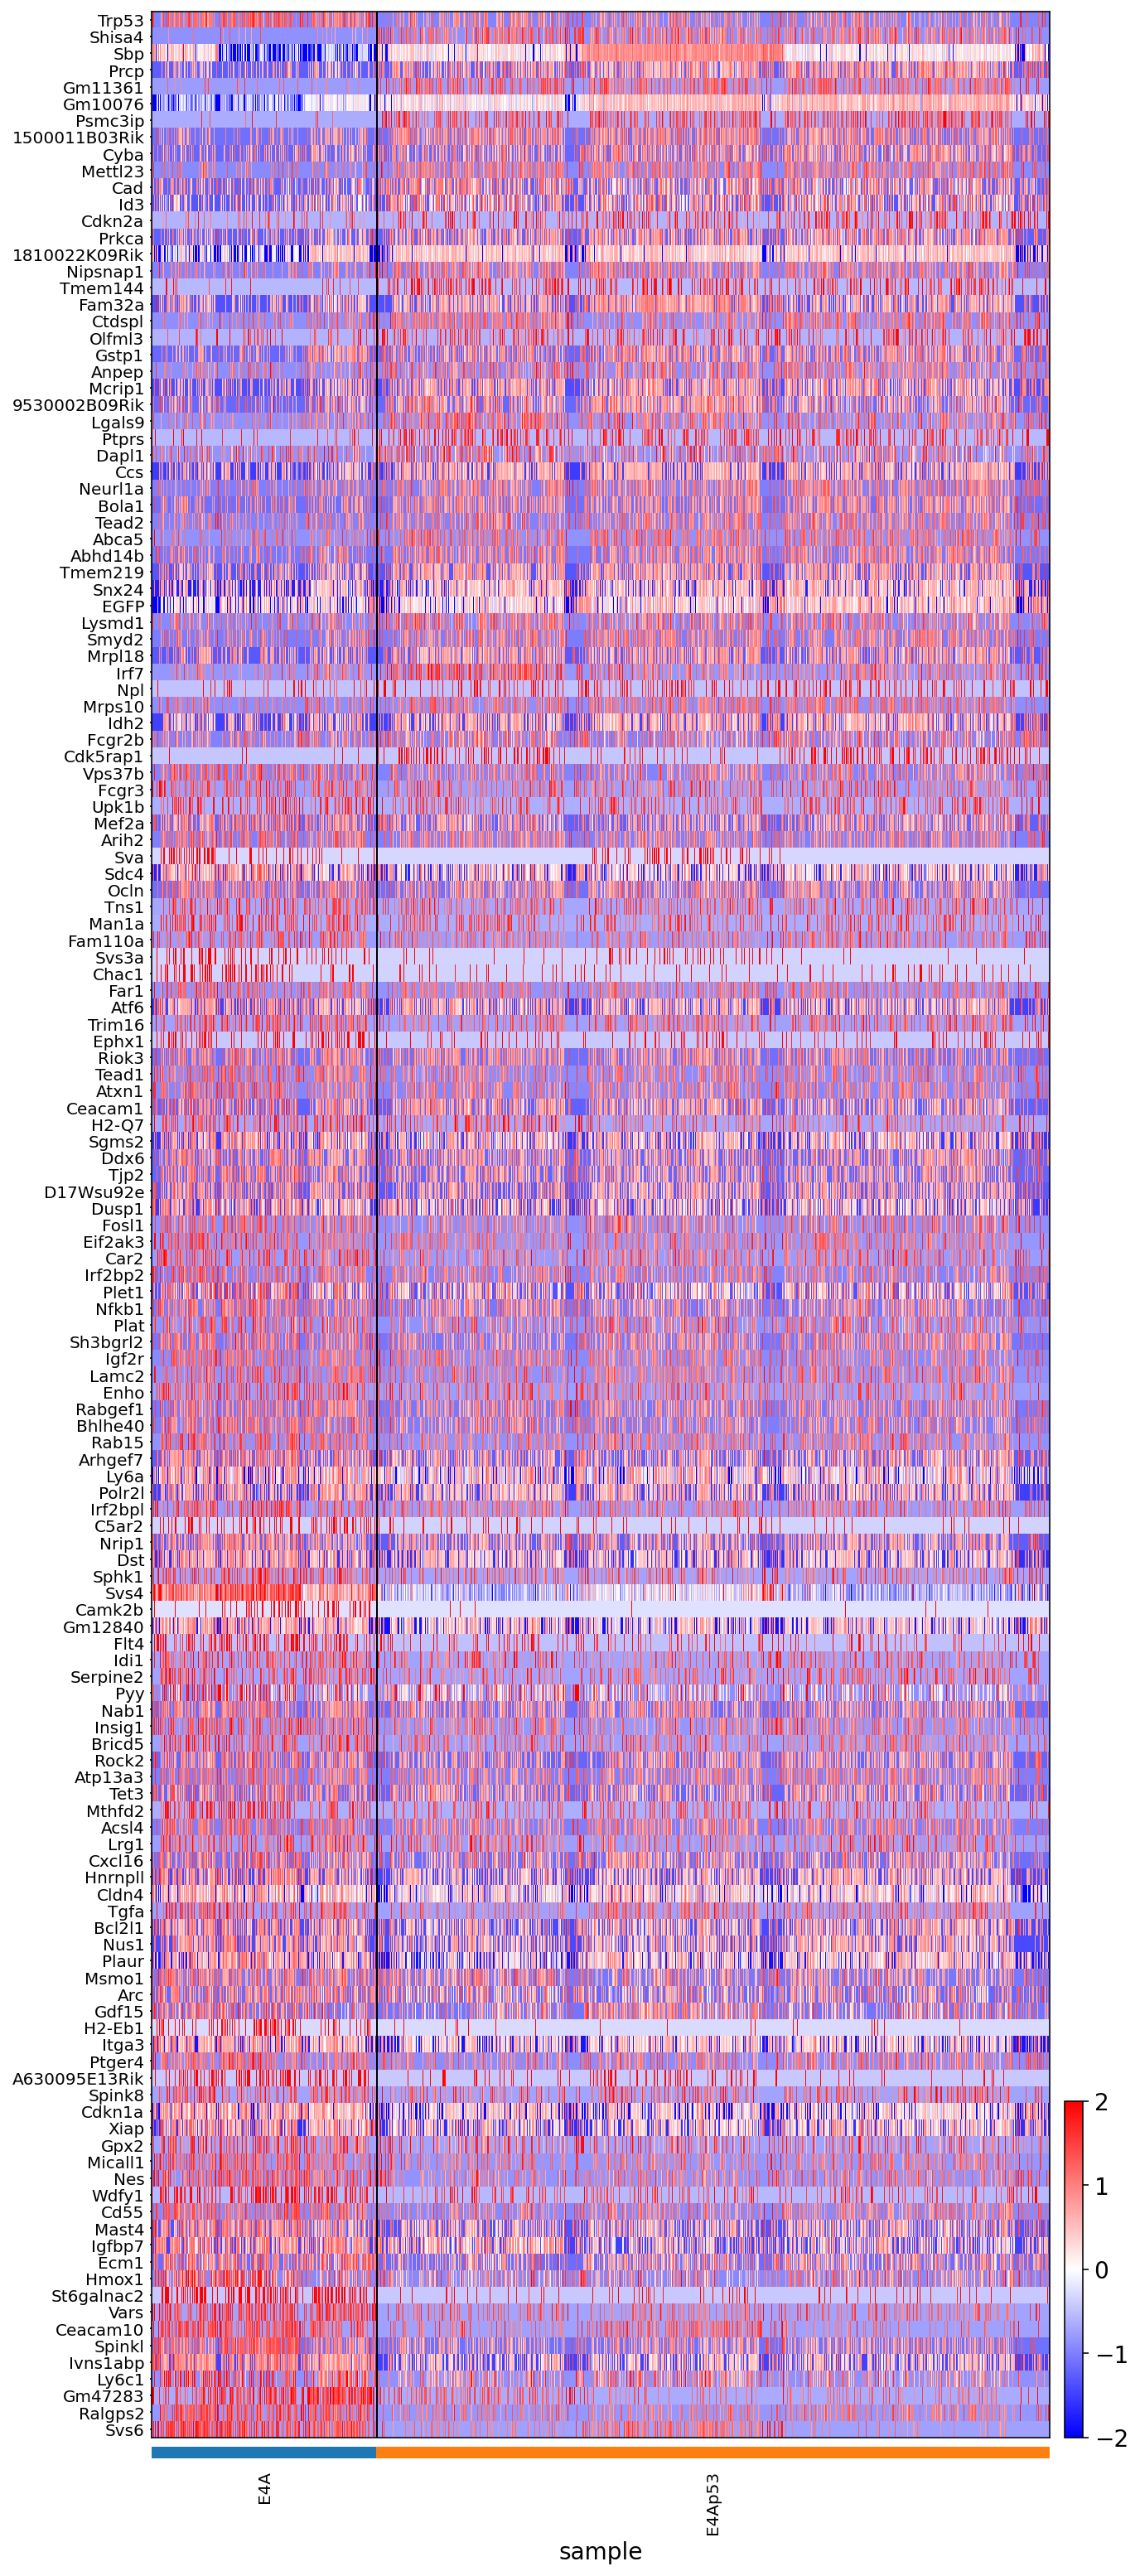

In [246]:
plt.rcParams.update({'font.size': 12})
sc.pl.heatmap(E4A_E4Ap53_4months_Luminal_1, genes, groupby='sample', 
              use_raw=False,
              #cmap = mycolormap_2,
              vmin=-2, vmax=2, show_gene_labels= True,
              cmap='bwr', dendrogram=False, swap_axes=True, 
              save = "Luminal_imputation_E4A_E4Ap53_4months_luminal_1_fcHurdleSig.pdf")

In [314]:
fcHurdle

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
1,p00001,4.990473e-04,-0.248218,-0.095440,-0.400995,1.260987e-02
2,p00002,1.304794e-15,1.028520,1.391037,0.666002,5.157353e-13
3,p00003,6.588571e-03,NaN,NaN,NaN,8.863603e-02
4,p00004,3.496304e-01,NaN,NaN,NaN,7.445119e-01
5,p00005,2.219118e-01,0.226970,0.512227,-0.058286,6.191454e-01
...,...,...,...,...,...,...
16597,p19850,3.490622e-01,NaN,NaN,NaN,7.441610e-01
16598,p19851,9.924641e-01,NaN,NaN,NaN,1.000000e+00
16599,p19852,4.830184e-01,0.238162,0.640195,-0.163871,8.303395e-01
16600,p19853,4.030713e-01,0.321872,0.802857,-0.159113,7.739103e-01


In [315]:
%%R -o fcHurdle_genes
library(data.table)
fcHurdle_genes <- merge(fcHurdle, as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdle_genes, fdr)

#### -log(p-value) * sign(logFC)

In [316]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * np.sign(fcHurdle_genes['coef'])
fcHurdle_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,1.189355e-226,NaN,NaN,NaN,1.974449e-222,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,NaN
2,p13789,7.653504e-139,NaN,NaN,NaN,6.352791e-135,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,NaN
3,p02491,4.081132e-115,-1.272633,-1.180056,-1.365209,2.258362e-111,Svs4,34938,0,1.240235,1.228496,4.090656,1.240235,1.234352,-110.646206
4,p12021,2.680877e-100,2.085934,2.346163,1.825706,1.112631e-96,Gm10076,38551,0,1.072671,0.557249,0.049161,1.072671,0.773140,95.953649
5,p02494,2.232929e-65,NaN,NaN,NaN,7.413772e-62,Svs5,46845,0,2.129481,0.990046,2.654979,2.129481,1.451993,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16597,p19714,9.518332e-01,-0.073372,0.386393,-0.533136,1.000000e+00,Lzts2,10749,0,0.144823,0.725120,0.142021,0.144823,0.324059,0.000000
16598,p19765,9.353378e-01,0.006905,0.227939,-0.214129,1.000000e+00,Stn1,4676,0,0.059366,0.765880,0.110972,0.059366,0.213231,-0.000000
16599,p19790,9.656152e-01,0.009529,0.096338,-0.077280,1.000000e+00,Gpam,213,0,0.002499,0.835022,0.026081,0.002499,0.045683,-0.000000
16600,p19801,9.304416e-01,-0.031533,0.159368,-0.222433,1.000000e+00,Plekhs1,4642,0,0.057978,0.805084,0.599954,0.057978,0.216050,0.000000


In [317]:
fcHurdle_genes.sort_values(by=['coef'])
fcHurdle_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,1.189355e-226,NaN,NaN,NaN,1.974449e-222,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,NaN
2,p13789,7.653504e-139,NaN,NaN,NaN,6.352791e-135,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,NaN
3,p02491,4.081132e-115,-1.272633,-1.180056,-1.365209,2.258362e-111,Svs4,34938,0,1.240235,1.228496,4.090656,1.240235,1.234352,-110.646206
4,p12021,2.680877e-100,2.085934,2.346163,1.825706,1.112631e-96,Gm10076,38551,0,1.072671,0.557249,0.049161,1.072671,0.773140,95.953649
5,p02494,2.232929e-65,NaN,NaN,NaN,7.413772e-62,Svs5,46845,0,2.129481,0.990046,2.654979,2.129481,1.451993,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16597,p19714,9.518332e-01,-0.073372,0.386393,-0.533136,1.000000e+00,Lzts2,10749,0,0.144823,0.725120,0.142021,0.144823,0.324059,0.000000
16598,p19765,9.353378e-01,0.006905,0.227939,-0.214129,1.000000e+00,Stn1,4676,0,0.059366,0.765880,0.110972,0.059366,0.213231,-0.000000
16599,p19790,9.656152e-01,0.009529,0.096338,-0.077280,1.000000e+00,Gpam,213,0,0.002499,0.835022,0.026081,0.002499,0.045683,-0.000000
16600,p19801,9.304416e-01,-0.031533,0.159368,-0.222433,1.000000e+00,Plekhs1,4642,0,0.057978,0.805084,0.599954,0.057978,0.216050,0.000000


In [318]:
fcHurdle_genes[fcHurdle_genes['coef'].isnull().values]

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,1.189355e-226,NaN,NaN,NaN,1.974449e-222,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,NaN
2,p13789,7.653504e-139,NaN,NaN,NaN,6.352791e-135,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,NaN
5,p02494,2.232929e-65,NaN,NaN,NaN,7.413772e-62,Svs5,46845,0,2.129481,0.990046,2.654979,2.129481,1.451993,NaN
10,p18333,3.144929e-46,NaN,NaN,NaN,5.220896e-43,BC023719,2980,0,0.031847,0.665552,-1.284648,0.031847,0.145588,NaN
18,p14655,2.183900e-32,NaN,NaN,NaN,2.014162e-29,BC018473,1527,1,0.034044,1.717373,11.450604,0.034044,0.241799,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16557,p19135,9.690122e-01,NaN,NaN,NaN,1.000000e+00,Stard6,218,0,0.003229,0.876805,0.378441,0.003229,0.053212,NaN
16576,p19399,9.330231e-01,NaN,NaN,NaN,1.000000e+00,1700092M07Rik,78,0,0.000826,0.718782,-0.835860,0.000826,0.024368,NaN
16587,p19629,9.842883e-01,NaN,NaN,NaN,1.000000e+00,Cep55,193,0,0.002045,0.691424,-1.136885,0.002045,0.037601,NaN
16593,p19681,9.913013e-01,NaN,NaN,NaN,1.000000e+00,Loxl4,121,0,0.001393,0.800363,-0.286792,0.001393,0.033392,NaN


In [319]:
fcHurdle_genes.iloc[1, 2]

nan

In [320]:
fcHurdle_genes['coef'][1] = -1.0

<ipython-input-320-d414701a3b31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcHurdle_genes['coef'][1] = -1.0


In [321]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * fcHurdle_genes['coef']
fcHurdle_genes

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,score
1,p15483,1.189355e-226,NaN,NaN,NaN,1.974449e-222,Gm10260,11655,1,0.339504,1.310855,6.899249,0.339504,0.667113,NaN
2,p13789,7.653504e-139,-1.000000,NaN,NaN,6.352791e-135,Trp53,20718,0,0.332485,0.662374,0.063405,0.332485,0.469286,-134.197035
3,p02491,4.081132e-115,-1.272633,-1.180056,-1.365209,2.258362e-111,Svs4,34938,0,1.240235,1.228496,4.090656,1.240235,1.234352,-140.811960
4,p12021,2.680877e-100,2.085934,2.346163,1.825706,1.112631e-96,Gm10076,38551,0,1.072671,0.557249,0.049161,1.072671,0.773140,200.153005
5,p02494,2.232929e-65,NaN,NaN,NaN,7.413772e-62,Svs5,46845,0,2.129481,0.990046,2.654979,2.129481,1.451993,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16597,p19714,9.518332e-01,-0.073372,0.386393,-0.533136,1.000000e+00,Lzts2,10749,0,0.144823,0.725120,0.142021,0.144823,0.324059,0.000000
16598,p19765,9.353378e-01,0.006905,0.227939,-0.214129,1.000000e+00,Stn1,4676,0,0.059366,0.765880,0.110972,0.059366,0.213231,-0.000000
16599,p19790,9.656152e-01,0.009529,0.096338,-0.077280,1.000000e+00,Gpam,213,0,0.002499,0.835022,0.026081,0.002499,0.045683,-0.000000
16600,p19801,9.304416e-01,-0.031533,0.159368,-0.222433,1.000000e+00,Plekhs1,4642,0,0.057978,0.805084,0.599954,0.057978,0.216050,0.000000


In [322]:
fcHurdle_genes.to_csv('./MAST/E4A_E4Ap53_4months_luminal_1/fcHurdle_genes.csv')

#### GSEA

In [323]:
%%R
head(fcHurdle)

  primerid   Pr(>Chisq)       coef       ci.hi       ci.lo          fdr
1   p00001 4.990473e-04 -0.2482179 -0.09544029 -0.40099548 1.260987e-02
2   p00002 1.304794e-15  1.0285197  1.39103738  0.66600206 5.157353e-13
3   p00003 6.588571e-03        NaN         NaN         NaN 8.863603e-02
4   p00004 3.496304e-01        NaN         NaN         NaN 7.445119e-01
5   p00005 2.219118e-01  0.2269702  0.51222676 -0.05828639 6.191454e-01
6   p00008 3.174557e-01        NaN         NaN         NaN 7.274863e-01


In [324]:
%%R -o fcHurdle
library(data.table)
fcHurdle <- merge(fcHurdle, as.data.table(mcols(sca)), by='primerid')
head(fcHurdle)

  primerid   Pr(>Chisq)       coef       ci.hi       ci.lo          fdr gene_id
1   p00001 4.990473e-04 -0.2482179 -0.09544029 -0.40099548 1.260987e-02   hETV4
2   p00002 1.304794e-15  1.0285197  1.39103738  0.66600206 5.157353e-13    EGFP
3   p00003 6.588571e-03        NaN         NaN         NaN 8.863603e-02 CreERT2
4   p00004 3.496304e-01        NaN         NaN         NaN 7.445119e-01    EYFP
5   p00005 2.219118e-01  0.2269702  0.51222676 -0.05828639 6.191454e-01   hETV4
6   p00008 3.174557e-01        NaN         NaN         NaN 7.274863e-01   Sox17
  n_cells highly_variable       means dispersions dispersions_norm        mean
1    9304               1 0.245906325   1.4271647         8.125310 0.245906325
2   10407               0 0.153405170   0.8349393         1.499609 0.153405170
3     163               0 0.003174699   1.2363847         3.410800 0.003174699
4    6591               1 0.261973219   2.5312355        19.763681 0.261973219
5     720               0 0.010206114   1.186

In [325]:
%%R
minim <- min(fcHurdle[fcHurdle$`fdr` > 0]$`fdr`)

In [326]:
%%R
head(fcHurdle[,FCtimesp := -log10(`fdr`+ minim) * sign(`coef`)])

  primerid   Pr(>Chisq)       coef       ci.hi       ci.lo          fdr gene_id
1   p00001 4.990473e-04 -0.2482179 -0.09544029 -0.40099548 1.260987e-02   hETV4
2   p00002 1.304794e-15  1.0285197  1.39103738  0.66600206 5.157353e-13    EGFP
3   p00003 6.588571e-03        NaN         NaN         NaN 8.863603e-02 CreERT2
4   p00004 3.496304e-01        NaN         NaN         NaN 7.445119e-01    EYFP
5   p00005 2.219118e-01  0.2269702  0.51222676 -0.05828639 6.191454e-01   hETV4
6   p00008 3.174557e-01        NaN         NaN         NaN 7.274863e-01   Sox17
  n_cells highly_variable       means dispersions dispersions_norm        mean
1    9304               1 0.245906325   1.4271647         8.125310 0.245906325
2   10407               0 0.153405170   0.8349393         1.499609 0.153405170
3     163               0 0.003174699   1.2363847         3.410800 0.003174699
4    6591               1 0.261973219   2.5312355        19.763681 0.261973219
5     720               0 0.010206114   1.186

In [327]:
%%R -o fcHurdleluminal_4m
fcHurdleluminal_4m <- fcHurdle

In [328]:
fcHurdleluminal_4m

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,FCtimesp
1,p00001,4.990473e-04,-0.248218,-0.095440,-0.400995,1.260987e-02,hETV4,9304,1,0.245906,1.427165,8.125310,0.245906,0.592409,-1.899289
2,p00002,1.304794e-15,1.028520,1.391037,0.666002,5.157353e-13,EGFP,10407,0,0.153405,0.834939,1.499609,0.153405,0.357888,12.287573
3,p00003,6.588571e-03,NaN,NaN,NaN,8.863603e-02,CreERT2,163,0,0.003175,1.236385,3.410800,0.003175,0.062651,NaN
4,p00004,3.496304e-01,NaN,NaN,NaN,7.445119e-01,EYFP,6591,1,0.261973,2.531236,19.763681,0.261973,0.814319,NaN
5,p00005,2.219118e-01,0.226970,0.512227,-0.058286,6.191454e-01,hETV4,720,0,0.010206,1.186699,3.145723,0.010206,0.110053,0.208207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16597,p19850,3.490622e-01,NaN,NaN,NaN,7.441610e-01,AC168977.2,14,0,0.000167,0.733450,-0.387120,0.000167,0.011059,NaN
16598,p19851,9.924641e-01,NaN,NaN,NaN,1.000000e+00,AC168977.1,167,0,0.001918,0.858370,0.165852,0.001918,0.040580,NaN
16599,p19852,4.830184e-01,0.238162,0.640195,-0.163871,8.303395e-01,AC149090.1,7544,0,0.114098,0.929673,2.726850,0.114098,0.325690,0.080744
16600,p19853,4.030713e-01,0.321872,0.802857,-0.159113,7.739103e-01,CAAA01118383.1,12212,0,0.158647,0.676830,-0.454938,0.158647,0.327685,0.111309


In [329]:
#2 weeks : ETV4p53 vs ETV4
fcHurdleluminal_4m[fcHurdleluminal_4m['gene_id']=='Cdkn1a']

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,FCtimesp
15108,p18107,1.659132e-16,-1.631485,-1.242152,-2.020818,7.248223e-14,Cdkn1a,35588,0,1.080477,0.760378,1.272177,1.080477,0.906405,-13.139768


In [330]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

In [331]:
fcHurdleluminal_4m.sort_values(by=['FCtimesp'], inplace = True)

In [332]:
fcHurdleluminal_4m.iloc[:10]

,primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std,FCtimesp
2073,p02491,4.081132e-115,-1.272633,-1.180056,-1.365209,2.258362e-111,Svs4,34938,0,1.240235,1.228496,4.090656,1.240235,1.234352,-110.646206
2075,p02493,2.068778e-59,-3.792238,-3.370909,-4.213568,4.906255e-56,Svs6,5811,1,0.105148,1.551357,11.233507,0.105148,0.403883,-55.309250
648,p00786,2.247813e-52,-2.795332,-2.404362,-3.186303,4.664493e-49,Ivns1abp,20868,0,0.351447,0.732121,0.798631,0.351447,0.507250,-48.331196
692,p00839,1.518919e-40,-3.149585,-2.682614,-3.616557,2.292326e-37,Ralgps2,8237,0,0.112279,0.765286,0.477497,0.112279,0.293130,-36.639724
15854,p18992,1.300847e-39,-2.752442,-2.306195,-3.198688,1.799614e-36,Spinkl,8945,1,0.173623,1.868429,13.490509,0.173623,0.569563,-35.744821
12254,p14654,2.901744e-37,-2.301345,-1.917494,-2.685197,3.705528e-34,St6galnac2,5467,0,0.068324,0.742063,-0.186080,0.068324,0.225169,-33.431150
15639,p18725,3.404179e-36,-2.875515,-2.436032,-3.314998,3.767518e-33,Gm47283,21665,0,0.405423,0.799105,1.504725,0.405423,0.569188,-32.423945
6772,p08058,2.152494e-30,-2.672138,-2.231105,-3.113171,1.880713e-27,Ceacam10,5411,1,0.088465,1.275626,6.511068,0.088465,0.335929,-26.725677
15210,p18221,1.937965e-29,-1.550982,-1.237952,-1.864013,1.608608e-26,H2-Eb1,9340,1,0.360963,2.985005,24.547014,0.360963,1.038016,-25.793550
11088,p13280,3.224275e-29,-1.277799,-0.984534,-1.571063,2.548866e-26,Camk2b,1440,0,0.017497,0.814910,0.211248,0.017497,0.119408,-25.593653


In [333]:
rankfile = fcHurdleluminal_4m[['gene_id','FCtimesp']]

In [334]:
#rankfile['FCtimesp'] = rankfile['FCtimesp']*(-1)
rankfile.sort_values(by=['FCtimesp'], inplace = True)
rankfile

/home/dan/miniconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,gene_id,FCtimesp
2073,Svs4,-110.646206
2075,Svs6,-55.309250
648,Ivns1abp,-48.331196
692,Ralgps2,-36.639724
15854,Spinkl,-35.744821
...,...,...
16580,Emx2,NaN
16593,Spry3,NaN
16596,AC125149.3,NaN
16597,AC168977.2,NaN


In [335]:
rankfile['gene_id'] = rankfile['gene_id'].str.upper()
rankfile['gene_id']

<ipython-input-335-498705786604>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankfile['gene_id'] = rankfile['gene_id'].str.upper()


2073           SVS4
2075           SVS6
648        IVNS1ABP
692         RALGPS2
15854        SPINKL
            ...    
16580          EMX2
16593         SPRY3
16596    AC125149.3
16597    AC168977.2
16598    AC168977.1
Name: gene_id, Length: 16601, dtype: object

In [336]:
import os, sys
import gseapy as gp
gmtfiles = os.listdir('./GSEA/gmt')

for i in gmtfiles:
    gp.prerank(rnk=rankfile,gene_sets= './GSEA/gmt/'+i,
               processes=12,min_size=10,max_size=19855,
               permutation_num=100, 
               outdir='GSEA/E4A_E4Ap53_4months_luminal_1/'+i, format='pdf', seed=6)

2022-02-24 12:06:23,535 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 12:06:23,576 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 12:12:38,809 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 12:12:38,848 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 12:15:52,116 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 12:15:52,155 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 12:16:03,645 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-02-24 12:16:03,683 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-02-24 12:16:17,110 Input gene rankings contains NA values(gene name and ranking value), drop them a